In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt_colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']

import glob

import scipy.fft as fourier
import scipy.signal as signal
from scipy.stats import linregress
from scipy.optimize import curve_fit

In [2]:
def crear_csvs():

    filenames = glob.glob('Fotoconductividad/*.txt')
    for filename in filenames:
        file = open(filename)

        lines = []
        i = 0
        try:
            for line in file:
                i+=1
                if i>=17:
                    lines.append(line[:-1].split('\t'))
            data = pd.DataFrame(lines,columns=['Tiempo [s]','Voltaje [V]','Corriente [A]','Luz'])
            data.to_csv(filename[:-4]+'.csv',index=False)
        except BaseException as error:
            print('Error de lectura: '+filename)
            print(f'{error=}')
        file.close()
    
    filenames = glob.glob('Fotoconductividad/I_vs_V/*.txt')
    for filename in filenames:
        file = open(filename)

        lines = []
        i = 0
        try:
            for line in file:
                _,I,_,V,_ = line[:-1].split('\t')
                lines.append([I,V])
            data = pd.DataFrame(lines,columns=['Corriente [A]','Voltaje [V]'])
            data.to_csv(filename[:-4]+'.csv',index=False)
        except BaseException as error:
            print('Error de lectura: '+filename)
            print(f'{error=}')
        file.close()

# crear_csvs()

In [3]:
def procesar_datos_foto(nombre,axes,rango=(0,100000),filter_function=None,filter_cut=None,ajuste=False,ax_single=False,reg_avg=False):
    data = pd.read_csv('Fotoconductividad/'+nombre)
    corriente = np.array(data['Corriente [A]']*1e6)[rango[0]:rango[1]]
    tiempo = np.array(data['Tiempo [s]'][rango[0]:rango[1]])
    luz = np.array(data['Luz'])[rango[0]:rango[1]]
    
    fontsize = 12
    
    delta_y = np.amax(corriente)-np.amin(corriente)
    
    rango_calculos = (tiempo>120) & (tiempo<240)
    I0 = np.amin(corriente[rango_calculos])
    Delta_I0 = np.amax(corriente[rango_calculos]) - I0
    tau = -1.
    
    if filter_function is not None:
        
        corriente = filter_function(corriente,tiempo,cut)
        
        
        I0 = np.amin(corriente[rango_calculos])
        Delta_I0 = np.amax(corriente[rango_calculos]) - I0
    
    if ajuste:
        corriente = normalizar(tiempo,corriente)
        
        I0 = np.amin(corriente[rango_calculos])
        Delta_I0 = np.amax(corriente[rango_calculos]) - I0
        
    
    if ax_single:
        inicio = 540
        rango_up = (tiempo>inicio) & (tiempo<inicio+60)
        tiempo_up = (tiempo-inicio)[rango_up]
        corriente_up = corriente[rango_up]
        luz_up = luz[rango_up]
        
        
        popt,pcov = ajuste_exp(tiempo_up,corriente_up,metadata=True)
        I0,Delta_I0,tau = popt[2],popt[0],popt[1]
    
    if reg_avg:
        params = []
        sigmas = []
        for inicio in range(60,900,120):
            rango_up = (tiempo>inicio) & (tiempo<inicio+60)
            tiempo_up = (tiempo-inicio)[rango_up]
            corriente_up = corriente[rango_up]
            luz_up = luz[rango_up]
        
            popt,pcov = ajuste_exp(tiempo_up,corriente_up,metadata=True)
#             print(inicio,popt)
            params.append(popt)
            sigmas.append([np.sqrt(pcov[j,j]) for j in range(len(popt))] )
            
            ajuste_up = exponencial_ajuste(tiempo_up,*popt)
        
#         params = np.array(params).T
#         sigmas = np.array(sigmas).T
        
        sigmas = np.std(params,axis=0)
        params = np.mean(params,axis=0)
        
#         params = np.array([promedio(0*params[i],params[i],sigmas[i]) for i in range(len(params)) ])
#         sigmas = params[:,1]
#         params = params[:,0]
#         print(params,'\n',sigmas)
        
        tiempo = np.linspace(0,60)
        
        corriente = exponencial_ajuste(tiempo,*params)
        
        I0,Delta_I0,tau = params[2],params[0],params[1]
        return (corriente,tiempo,luz),(I0,Delta_I0,tau),(sigmas[2],sigmas[0],sigmas[1])


    return (corriente,tiempo,luz),(I0,Delta_I0,tau)

In [4]:
def extraer_datos_foto(nombre,axes,rango=(0,100000),filter_function=None,filter_cut=None,ajuste=None,ax_single=None,reg_avg=None):
    
    (corriente,tiempo,luz),(I0,Delta_I0,tau) = procesar_datos_foto(nombre,axes,rango)
    fontsize = 12
    
    fig_original = axes[0]
    fig_original.plot(tiempo,corriente)
    fig_original.fill_between(tiempo,luz*1.5*np.amax(corriente),alpha=0.15,color='darkorange',label='Encendido')
    
    delta_y = np.amax(corriente)-np.amin(corriente)
    fig_original.set_xlim(0,900)
    fig_original.set_ylim(np.amin(corriente),np.amin(corriente)+(delta_y*1.))
    fig_original.legend(fontsize=fontsize)
    fig_original.label_outer()
    fig_original.set_xlabel('Tiempo [s]',fontsize=fontsize)
    fig_original.set_ylabel('Corriente [$\mu$A]',fontsize=fontsize)
    fig_original.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    fig_original.yaxis.set_major_locator(plt.MaxNLocator(4))
    
    if filter_function is not None:
        
        (corriente,tiempo,luz),(I0,Delta_I0,tau) = procesar_datos_foto(nombre,axes,rango,filter_function,filter_cut)
        
        fig_filtrada = axes[1]
        fig_filtrada.plot(tiempo,corriente)
        fig_filtrada.fill_between(tiempo,luz*1.5*np.amax(corriente),alpha=0.15,color='darkorange',label='Encendido')
        
        delta_y = np.amax(corriente)-np.amin(corriente)
        fig_filtrada.set_xlim(0,900)
        fig_filtrada.set_ylim(np.amin(corriente),np.amin(corriente)+(delta_y*1.))
        fig_filtrada.label_outer()
        fig_filtrada.set_xlabel('Tiempo [s]',fontsize=fontsize)
        fig_filtrada.set_ylabel('Corriente [$\mu$A] \n Filtrada',fontsize=fontsize)
        fig_filtrada.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        fig_filtrada.yaxis.set_major_locator(plt.MaxNLocator(4))
        
        fig_original.set_ylabel('Original')
    
    if ajuste is not None:
        
        (corriente,tiempo,luz),(I0,Delta_I0,tau) = procesar_datos_foto(nombre,axes,rango,filter_function,filter_cut,
                                                                  ajuste is not None)
        
        fig_normalizada = axes[2]
        fig_normalizada.plot(tiempo,corriente)
        fig_normalizada.fill_between(tiempo,luz*1.5*np.amax(corriente),alpha=0.15,color='darkorange',label='Encendido')
        
        delta_y = np.amax(corriente)-np.amin(corriente)
        fig_normalizada.set_xlim(0,900)
        fig_normalizada.set_ylim(np.amin(corriente)-(delta_y*0.2),np.amin(corriente)+(delta_y*1.2))
        fig_normalizada.label_outer()
        fig_normalizada.set_xlabel('Tiempo [s]',fontsize=fontsize)
        fig_normalizada.set_ylabel('Nivelada',fontsize=fontsize)
        fig_normalizada.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        fig_normalizada.yaxis.set_major_locator(plt.MaxNLocator(4))
        
    
    if ax_single is not None:
        inicio = 540
        rango_up = (tiempo>inicio) & (tiempo<inicio+60)
        tiempo_up = (tiempo-inicio)[rango_up]
        corriente_up = corriente[rango_up]
        luz_up = luz[rango_up]
        
#         rango_down = (tiempo>180) & (tiempo<240)
#         tiempo_down = (tiempo-180)[rango_down]
#         corriente_down = corriente[rango_down]

        (corriente,tiempo,luz),(I0,Delta_I0,tau) = procesar_datos_foto(nombre,axes,rango,filter_function,filter_cut,
                                                                  ajuste is not None,ax_single is not None)
        
        ajuste_up = exponencial_ajuste(tiempo_up,Delta_I0,tau,I0)
        
        ax_single.scatter(tiempo,corriente,label='Mediciones')
        ax_single.plot(tiempo_up+inicio,ajuste_up,c='r',label='Ajuste')
        ax_single.fill_between(tiempo,luz*1.5*np.amax(corriente_up),alpha=0.15,color='darkorange')
        ax_single.set_xlim(inicio-10,inicio+60+10)
        deltaY = np.amax(corriente_up)-np.amin(corriente_up)
        ax_single.set_ylim(np.amin(corriente_up)-deltaY*0.1,np.amin(corriente_up)+deltaY*1.1 )
        ax_single.set_xlabel('Tiempo [s]')
        ax_single.legend()
    
    if reg_avg is not None:
        (corriente,tiempo,luz),(I0,Delta_I0,tau),(sigmaI,sigmaDelta,sigmaTau) = procesar_datos_foto(nombre,axes,rango,filter_function,filter_cut,
                                                                  ajuste is not None,ax_single is not None,reg_avg is not None)
            
        reg_avg.plot(tiempo,corriente)
        reg_avg.fill_between(tiempo,1.2*(np.amax(corriente)-np.amin(corriente))+np.amin(corriente),alpha=0.15,color='darkorange')
        reg_avg.set_ylim(np.amin(corriente),1.2*(np.amax(corriente)-np.amin(corriente))+np.amin(corriente))
        reg_avg.set_title( '$I_0 = {:.3f}\pm{:.3f}$ \t $\Delta I_0$ = {:.4f}$\pm${:.4f} \t $ \tau = {:.2f}\pm{:.2f}$'.format(
            I0,sigmaI,Delta_I0,sigmaDelta,tau,sigmaTau) )


    return I0,Delta_I0,tau

In [5]:
def calcular_area_cm2():
    A1 = 17/2
    A2 = 17*np.cos(np.arcsin(3*2/17))
    A3 = 17*np.cos(np.arcsin(6*2/17))
    
    AT = A1+2*A2+2*A3
    
    return AT*1e-2

def calcular_desempeño(I0,Delta_I0,power_perc,sigma_I0=0.,sigma_DI=0.):
    power_frac = power_perc/100
#     Irradiancia = 100e-3 # W/cm2
#     Irradiancia = 90e-3 * power_frac
#     Irradiancia = 12.675e-3 # Para 15%
#     Irradiancia = 12.675e-3 *9
    Irradiancia = 12.70e-3*power_frac
    A = np.pi*(1.7/2)**2
    A = calcular_area_cm2()
#     P = 5.79*1.1e-2
    P = Irradiancia*A
    r = Delta_I0/P
    s = Delta_I0/I0
    
    Sr = sigma_DI/P
    Ss = np.sqrt( (sigma_DI/I0)**2 + (sigma_I0*Delta_I0/I0**2)**2)
    
    return r,s,Sr,Ss

def basic_filter(corriente,tiempo,cut):
    origin = corriente[0]
#     sos = signal.butter(11, cut, 'bp', fs=1/9e-3, output='sos')
    sos = signal.butter(11, cut, 'lp', fs=1/9e-3, output='sos')
    filtered = signal.sosfiltfilt(sos, corriente)
    shift = filtered[0]
#     filtered[(tiempo<60)] = np.amin(filtered[(tiempo>60)])
    filtered += (origin-shift)
    return filtered

def constante_ajuste(x,a):
    return a

def cuadratica_ajuste(x,a,b,c):
    return a*x**2 + b*x + c

def exponencial_ajuste(x,A,tau,b):
    return A*(1-np.exp(-x/tau) ) + b

def promedio(x,y,sigma_y):
    popt,pcov = curve_fit(constante_ajuste,x,y,sigma=sigma_y,absolute_sigma=True)
    return popt[0],pcov[0][0]

def ajuste_lineal(tiempo,corriente,metadata=False):
    if metadata:
        return linregress(tiempo,corriente)
    else:
        m,b,*_ = linregress(tiempo,corriente)
        return m*tiempo + b

def ajuste(tiempo,corriente,metadata=False):
    if metadata:
        return curve_fit(cuadratica_ajuste,tiempo,corriente)
    else:
        popt,pcov = curve_fit(cuadratica_ajuste,tiempo[:100000],corriente[:100000])
        return cuadratica_ajuste(tiempo,*popt)
    
def ajuste_exp(tiempo,corriente,metadata=False):
    if metadata:
        return curve_fit(exponencial_ajuste,tiempo,corriente,bounds=(0, [5., 60., 5.]) )
    else:
        popt,pcov = curve_fit(exponencial_ajuste,tiempo,corriente,bounds=(0, [5., 60., 5.]) )
        return exponencial_ajuste(tiempo,*popt)
    
def normalizar(tiempo,corriente):
#     cond = (tiempo<60) | (tiempo 120 & tiempo 180)
    cond = (tiempo//60)%2 == 0
    
    popt,pcov = ajuste(tiempo[cond],corriente[cond],True)
    correccion = cuadratica_ajuste(tiempo,*popt)
    
#     popt,pcov = ajuste_exp(tiempo[cond],corriente[cond],True)
#     correccion = exponencial_ajuste(tiempo,*popt)
    
    c0 = np.mean(corriente[(tiempo<60)])
    corriente -= correccion#*cond
    corriente += c0 - np.mean(corriente[(tiempo<60)])
    corriente[(tiempo<60)] = np.amin(corriente[(tiempo>60)])
    return corriente

x = np.ones(3)
y = np.array([1.9,2.4,2.1])
sigma_y = np.array([0.2,0.4,0.2])
promedio(x,y,sigma_y)
# ajuste_promedio(x,y)

(2.0444444444467225, 0.017777777823966168)

In [6]:
# fig = plt.figure(figsize=(12,8))
# gs = fig.add_gridspec(1, hspace=0)
# ax = gs.subplots(sharex=True, sharey=False)
# I0,Delta_I0,tau = extraer_datos_foto('ContactosCobre_Prueba.csv',(ax,))
# ax.plot(np.linspace(0,900),exponencial_ajuste(np.linspace(0,900),34-31.0,50,31.0))
# plt.show(fig)

# calcular_desempeño(I0,Delta_I0,15)

<ipython-input-7-8c6affe17441>:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2,ax1 = plt.subplots(figsize=(12,8) )
<ipython-input-7-8c6affe17441>:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,2))


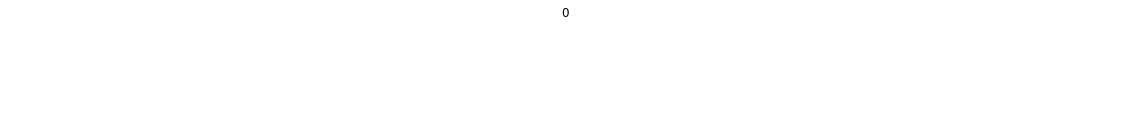

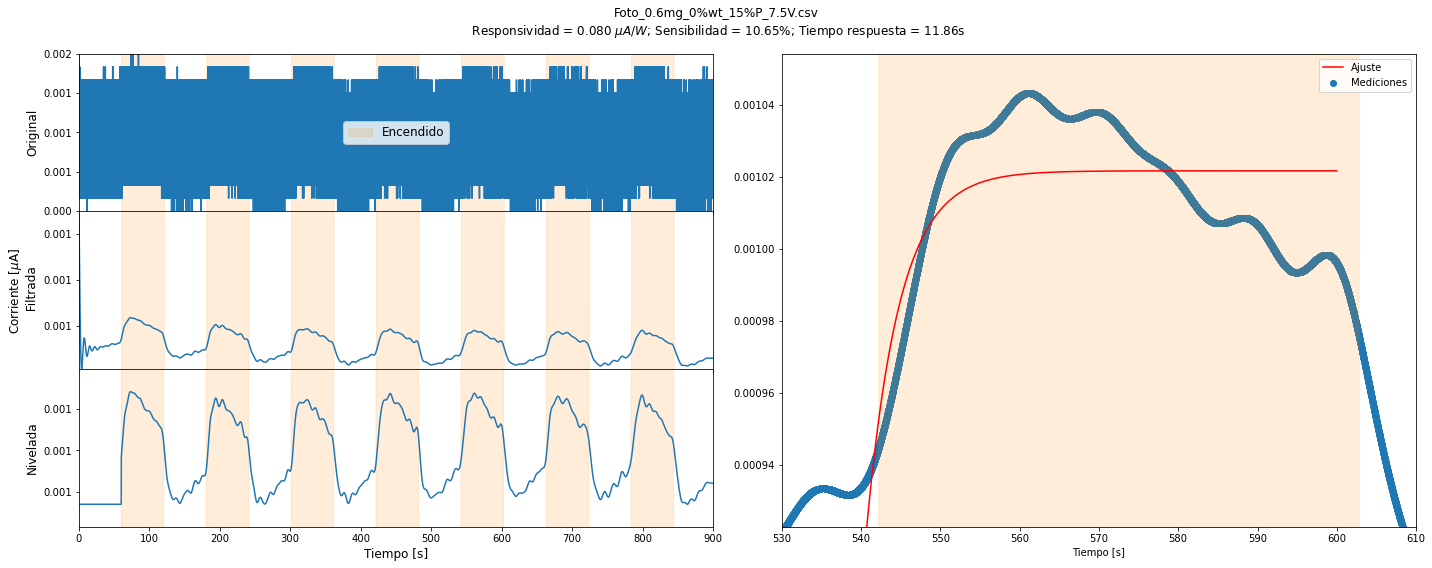

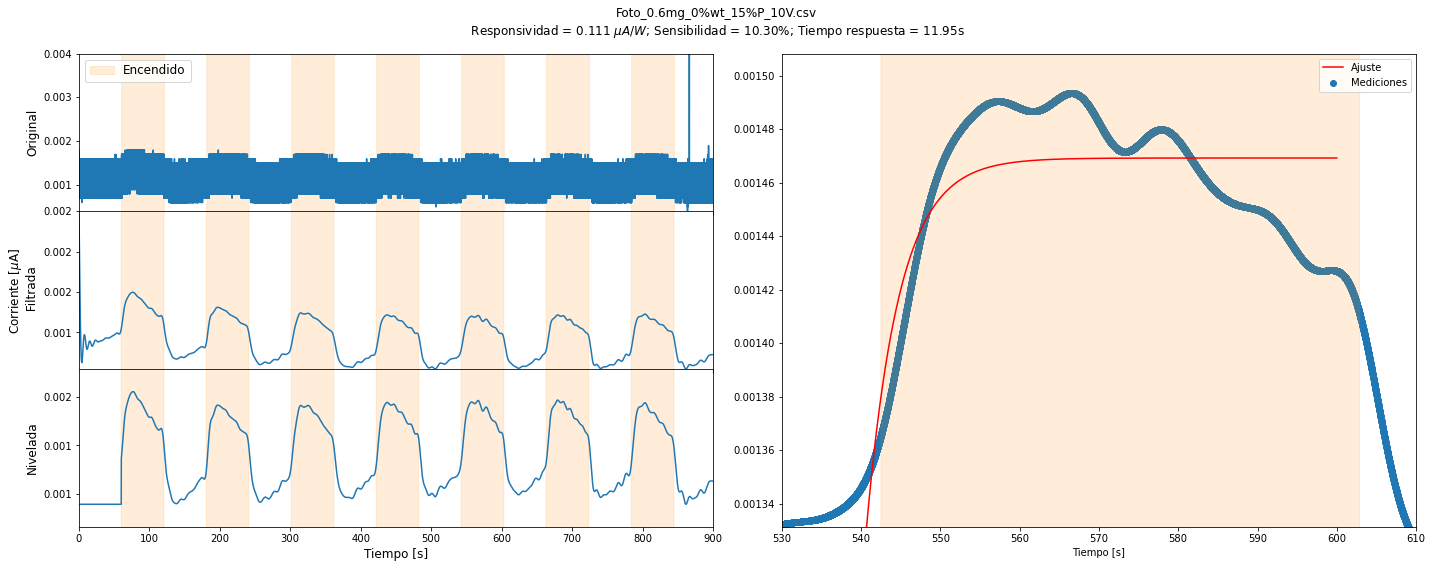

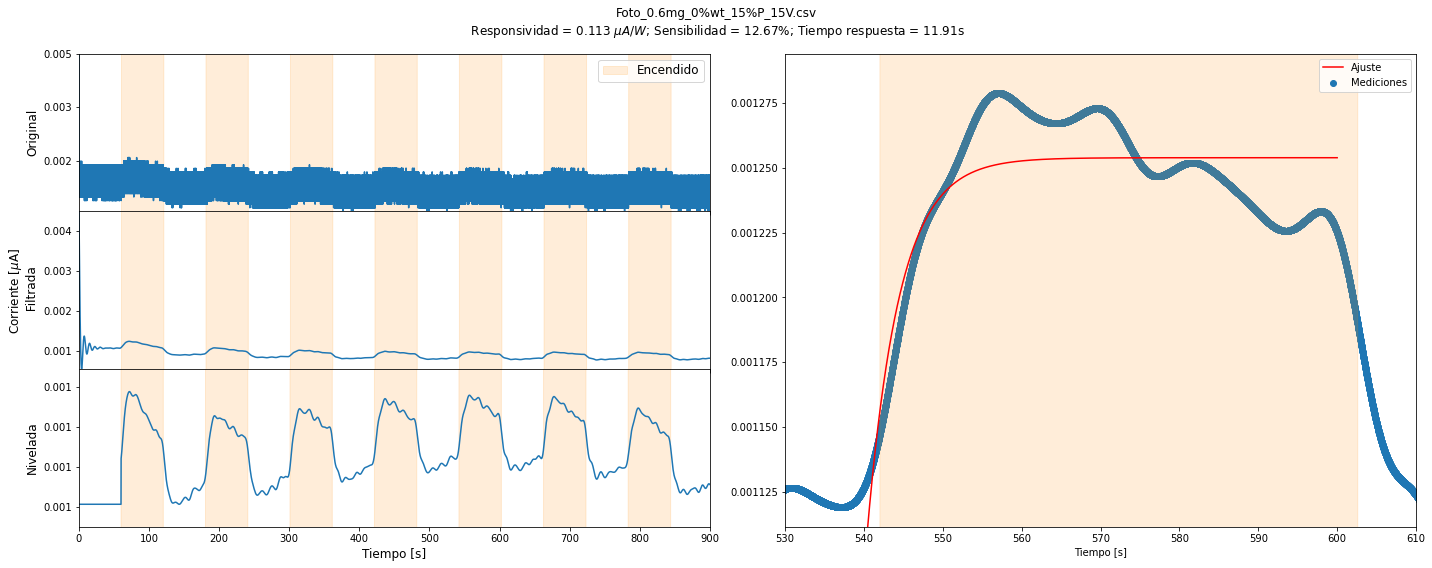

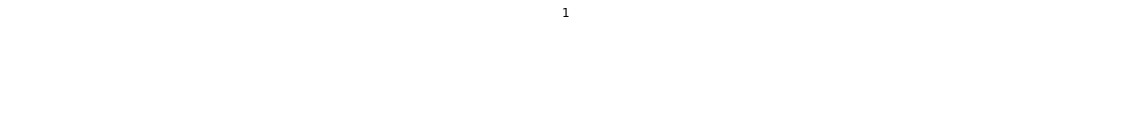

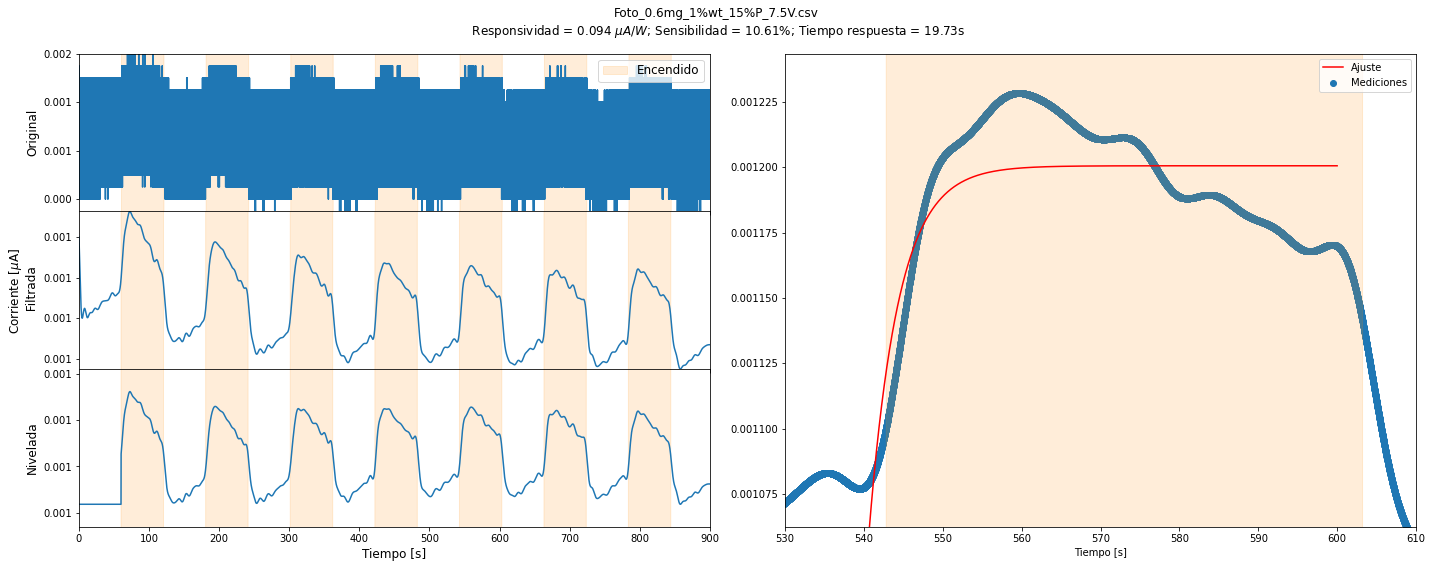

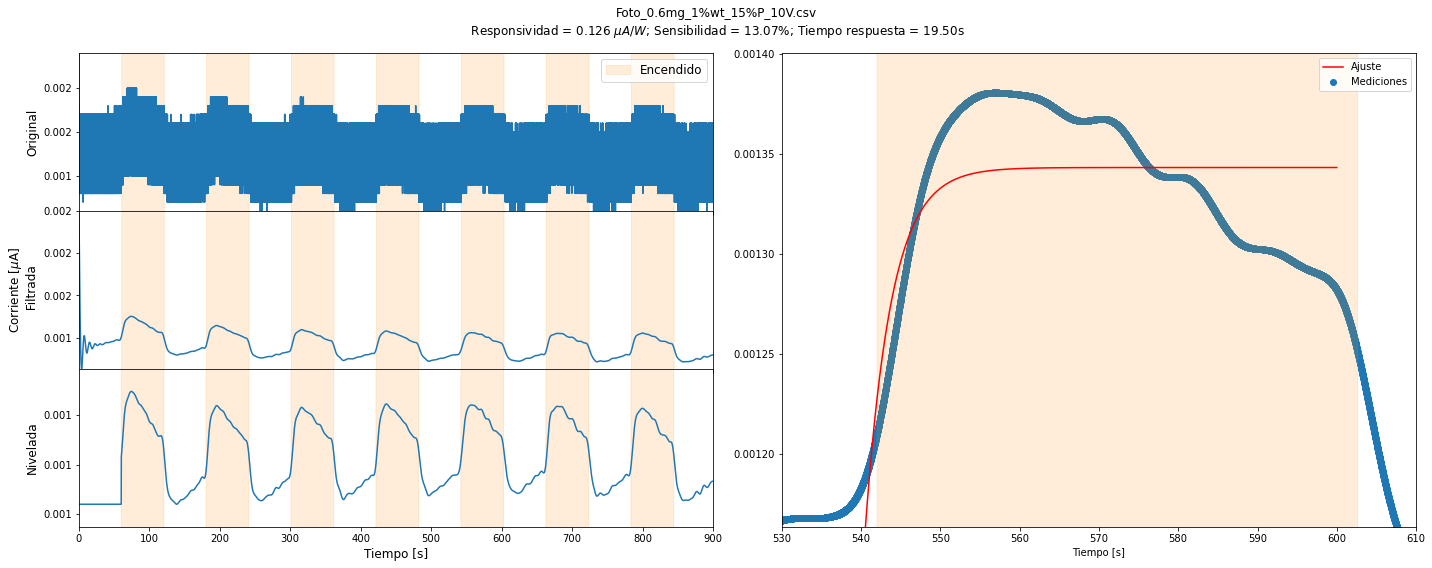

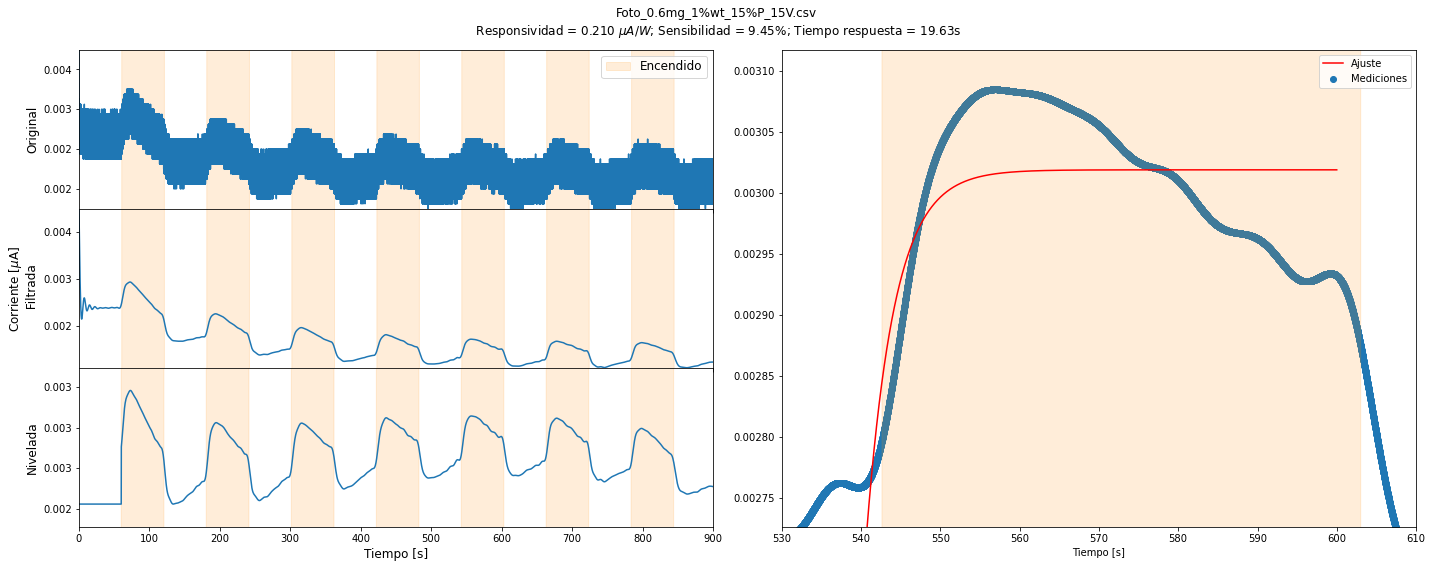

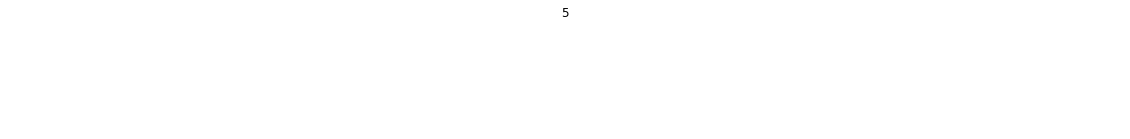

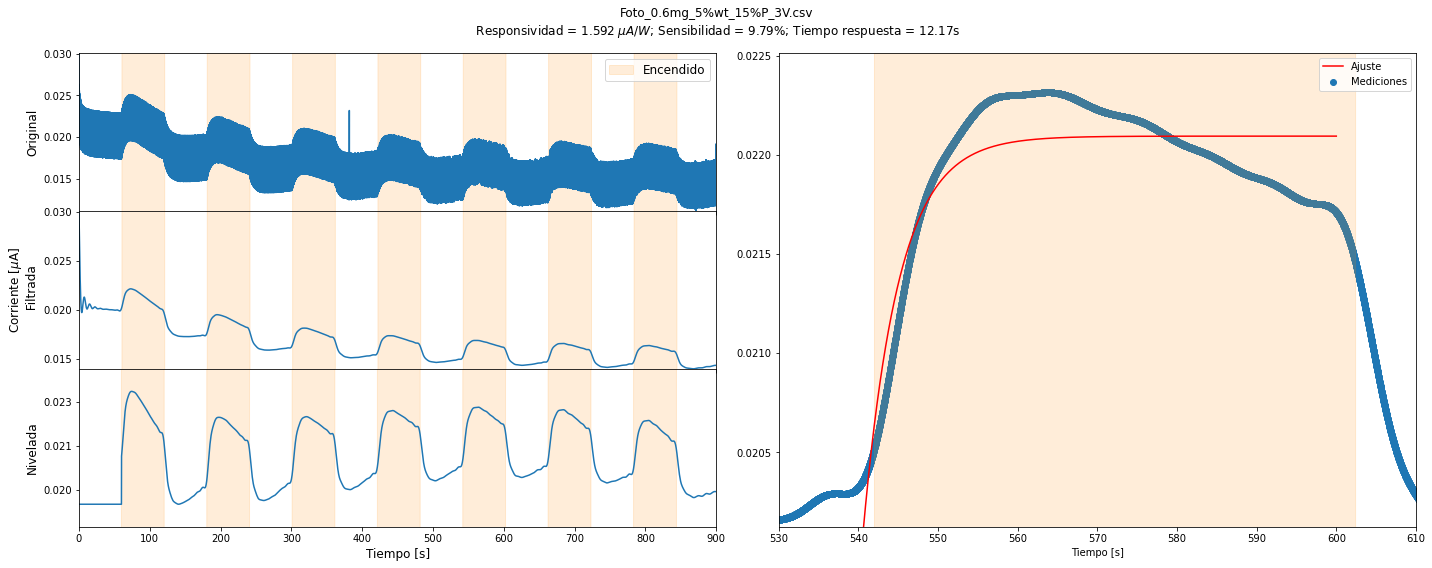

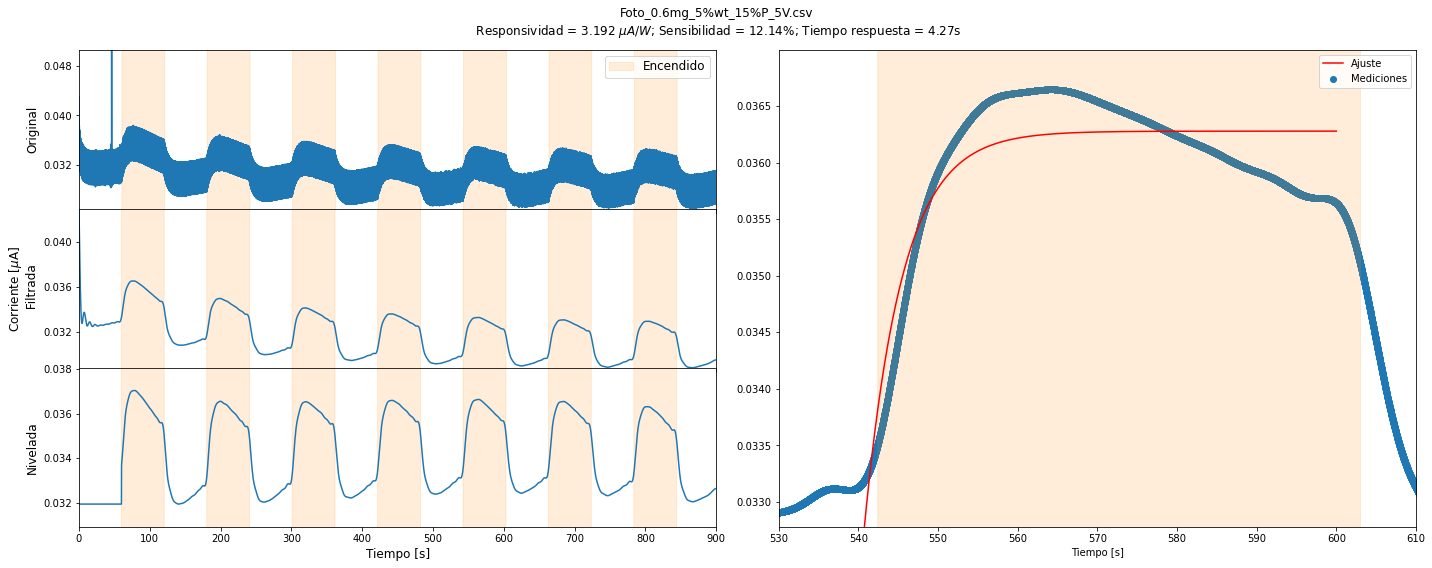

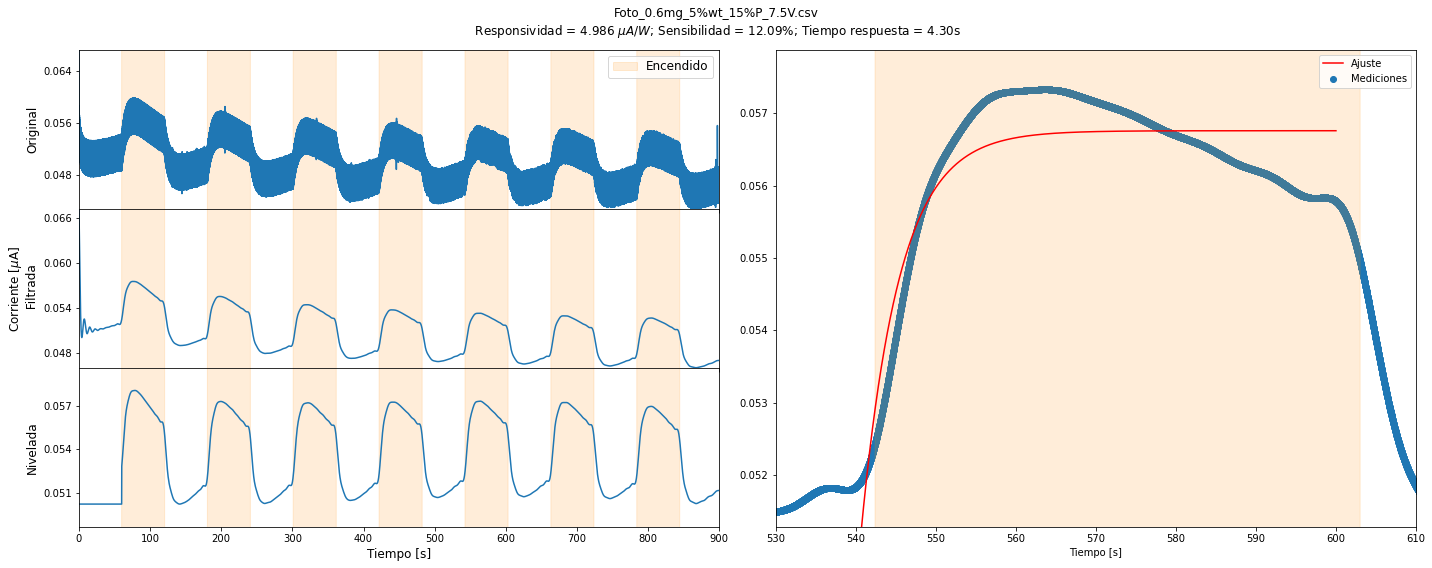

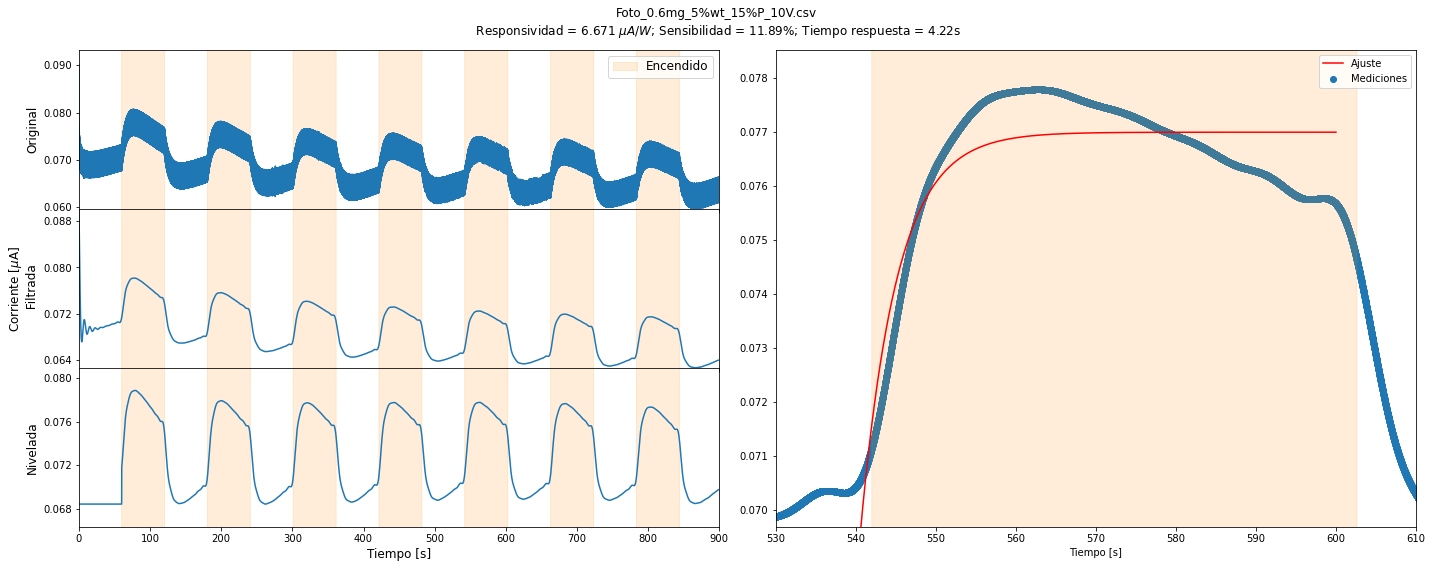

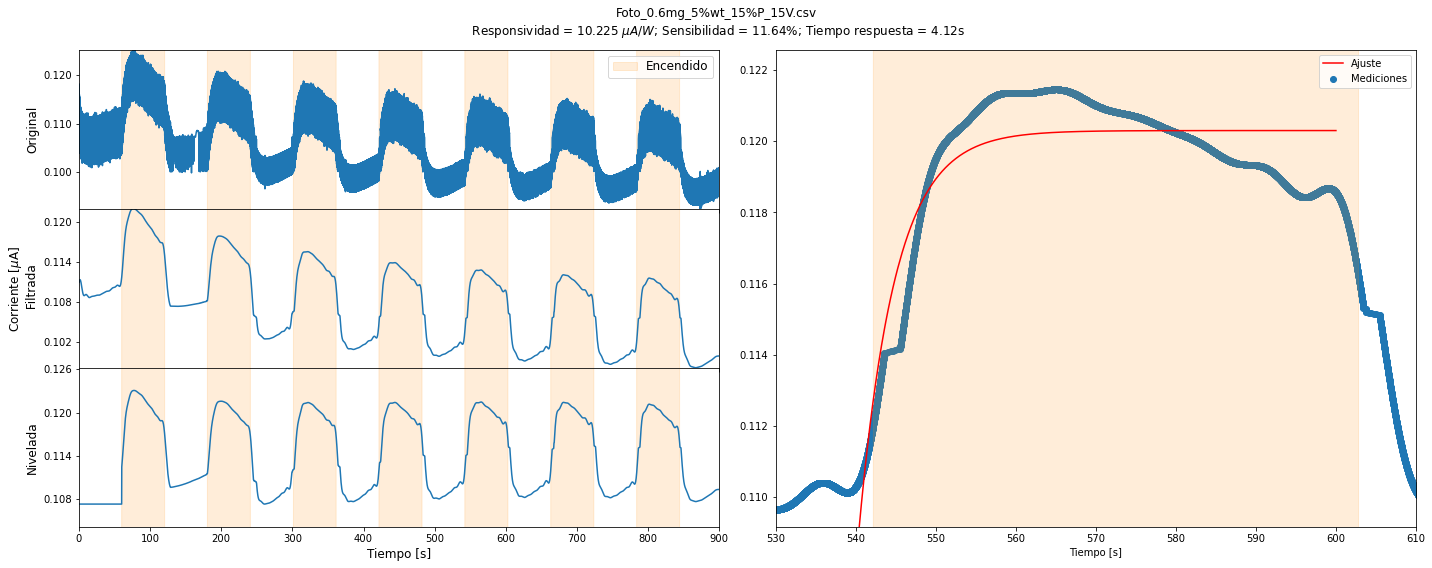

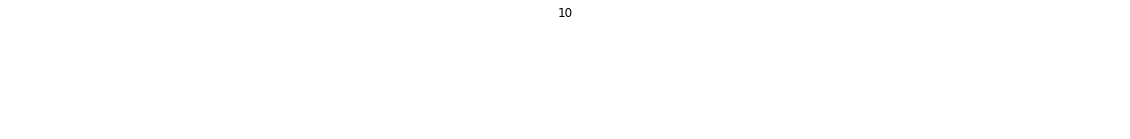

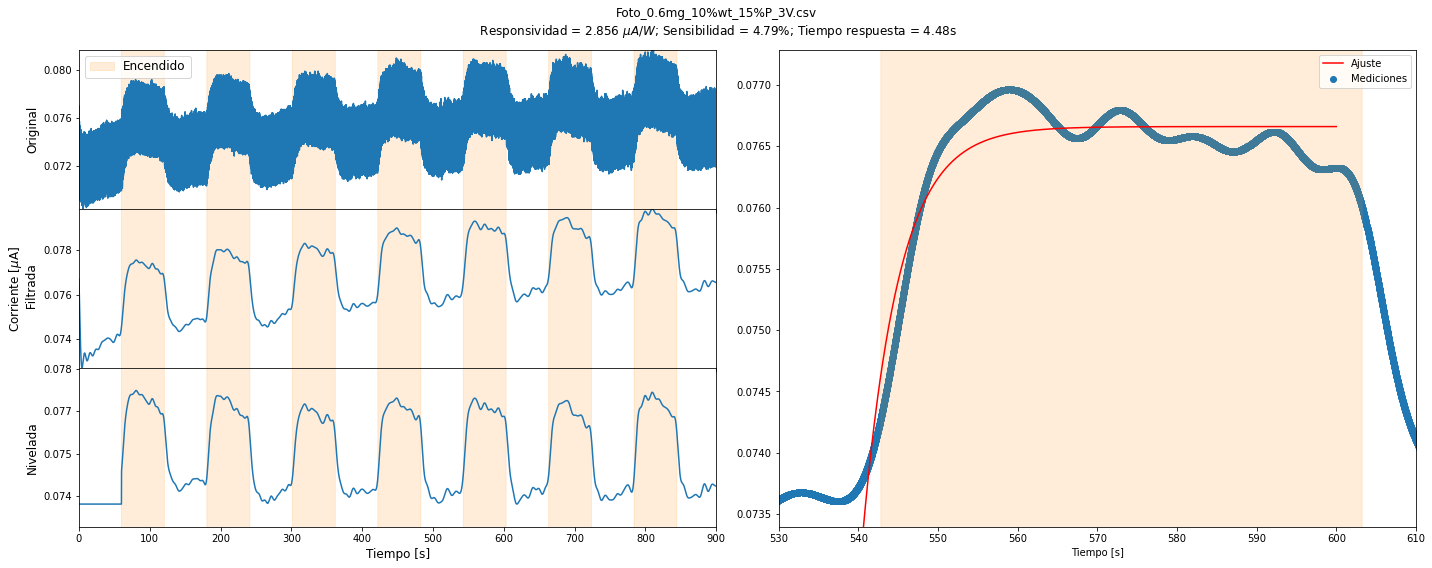

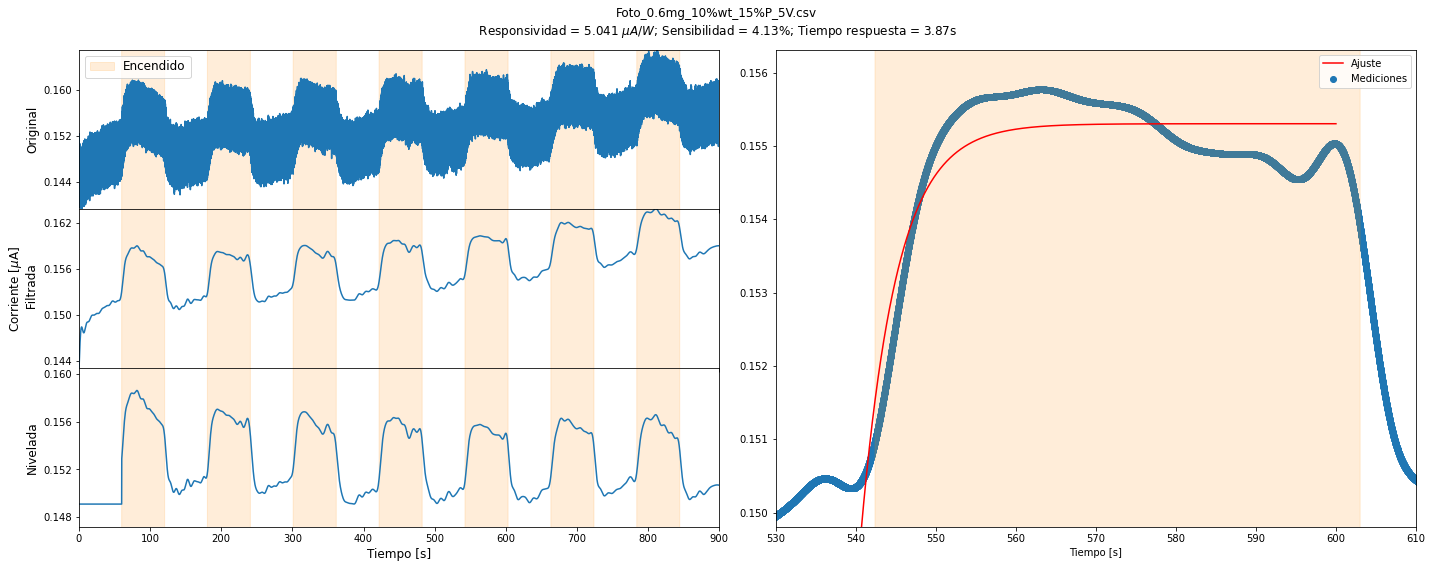

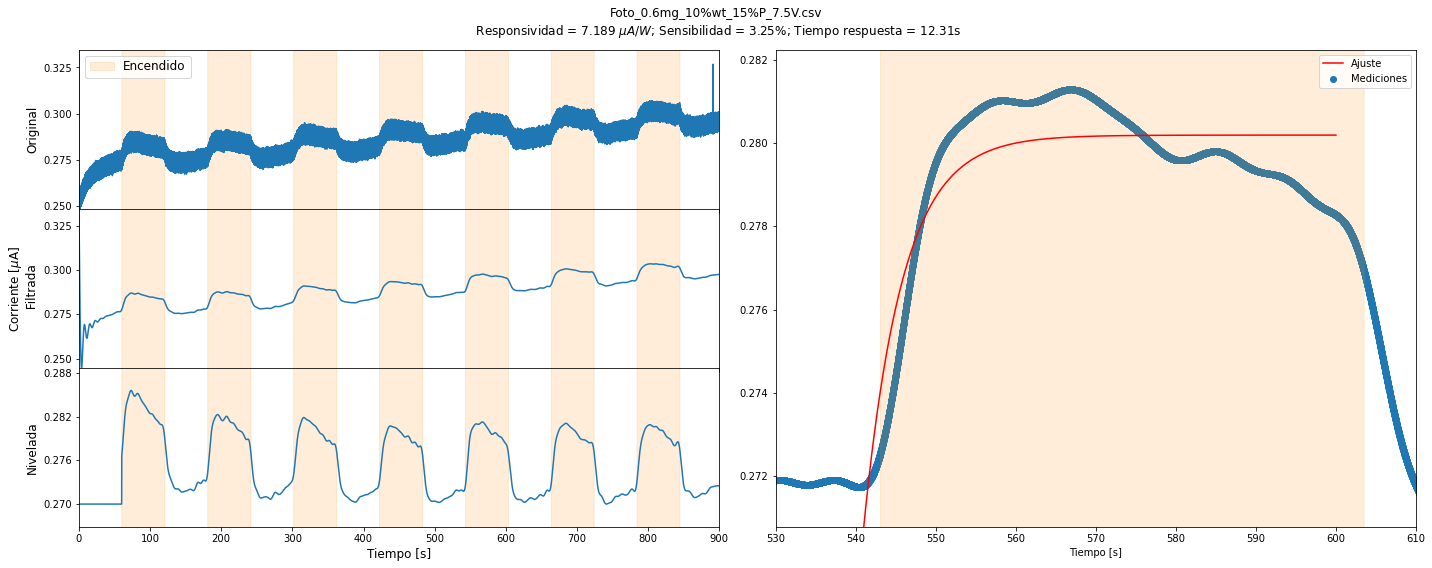

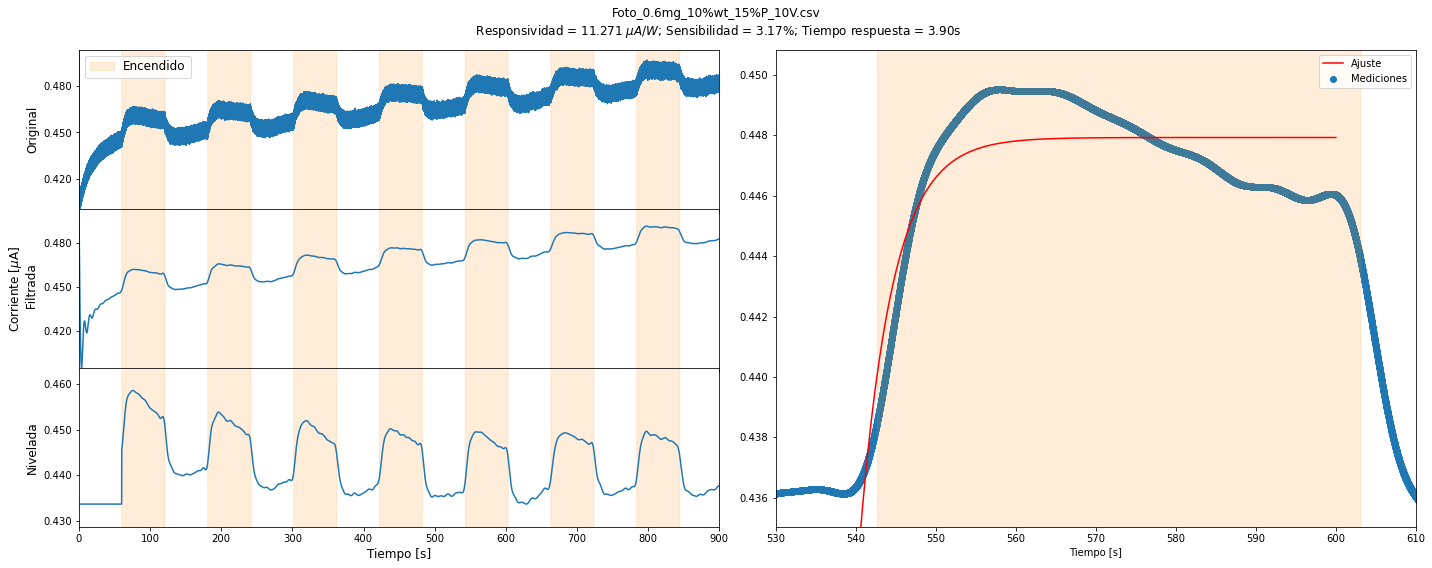

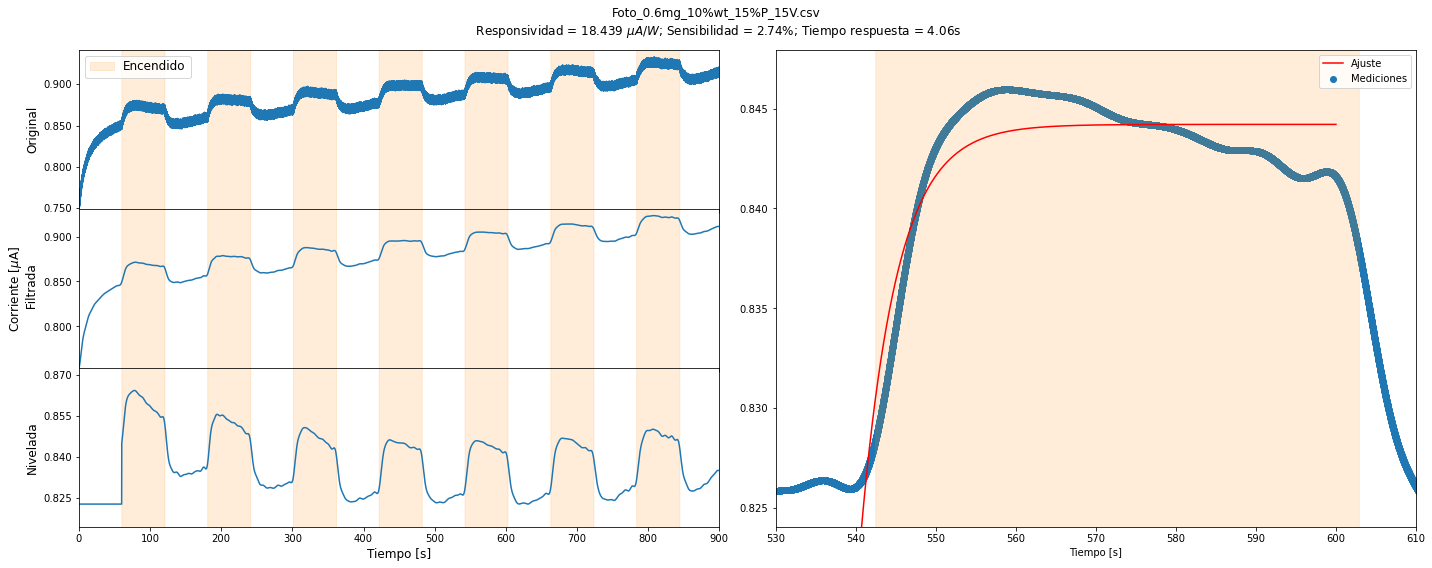

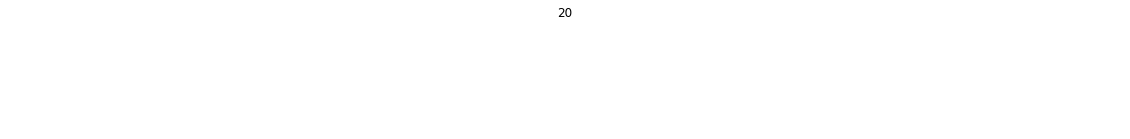

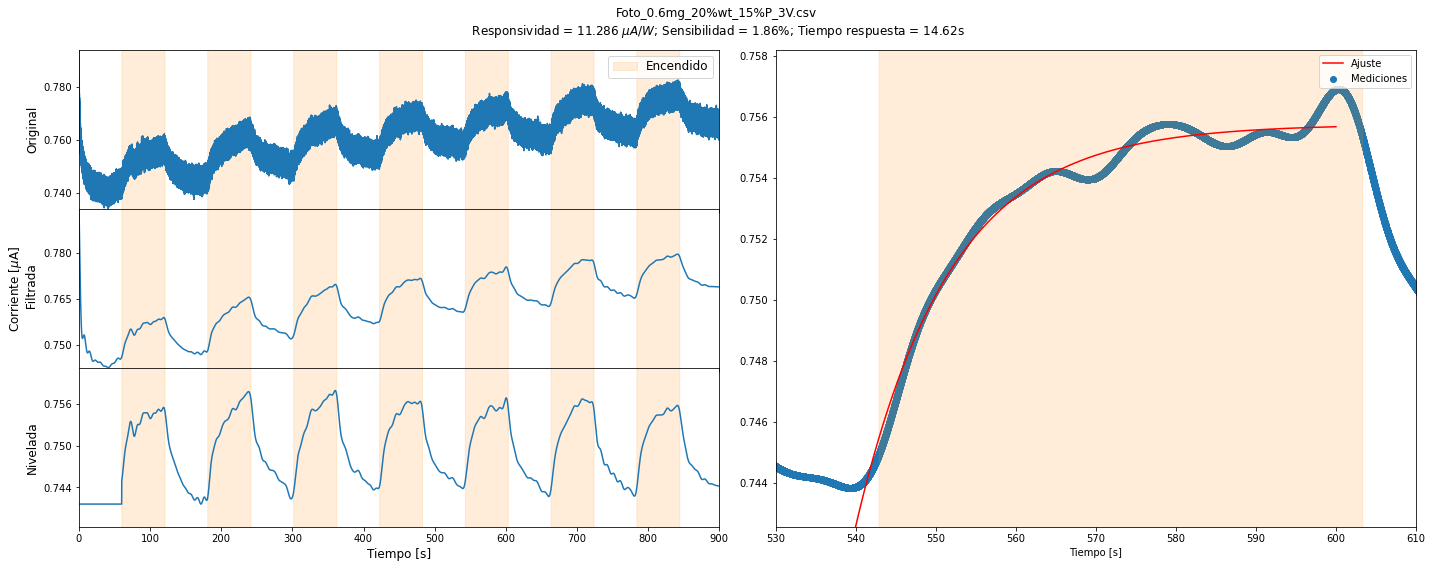

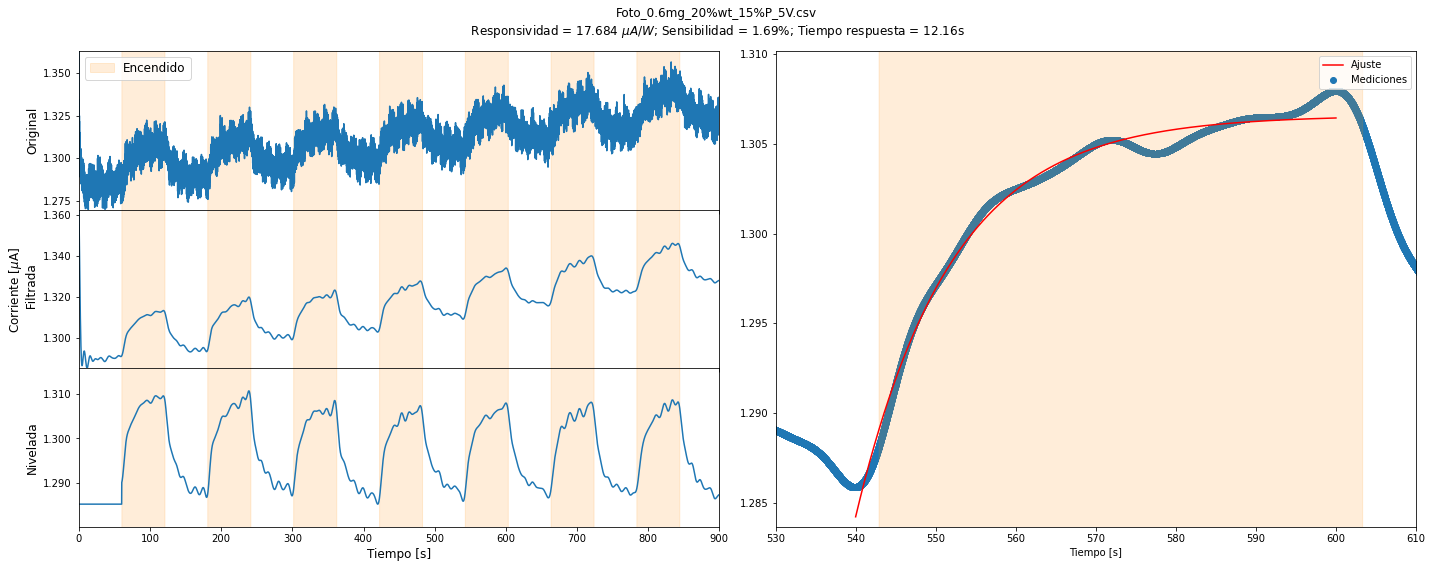

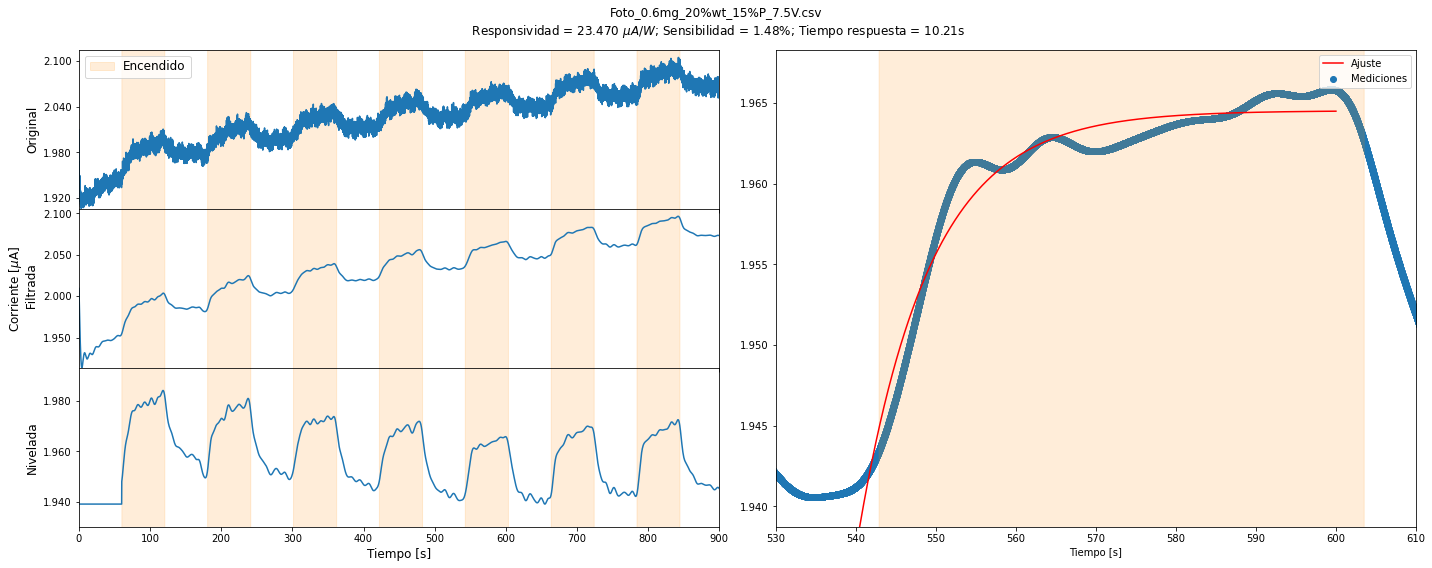

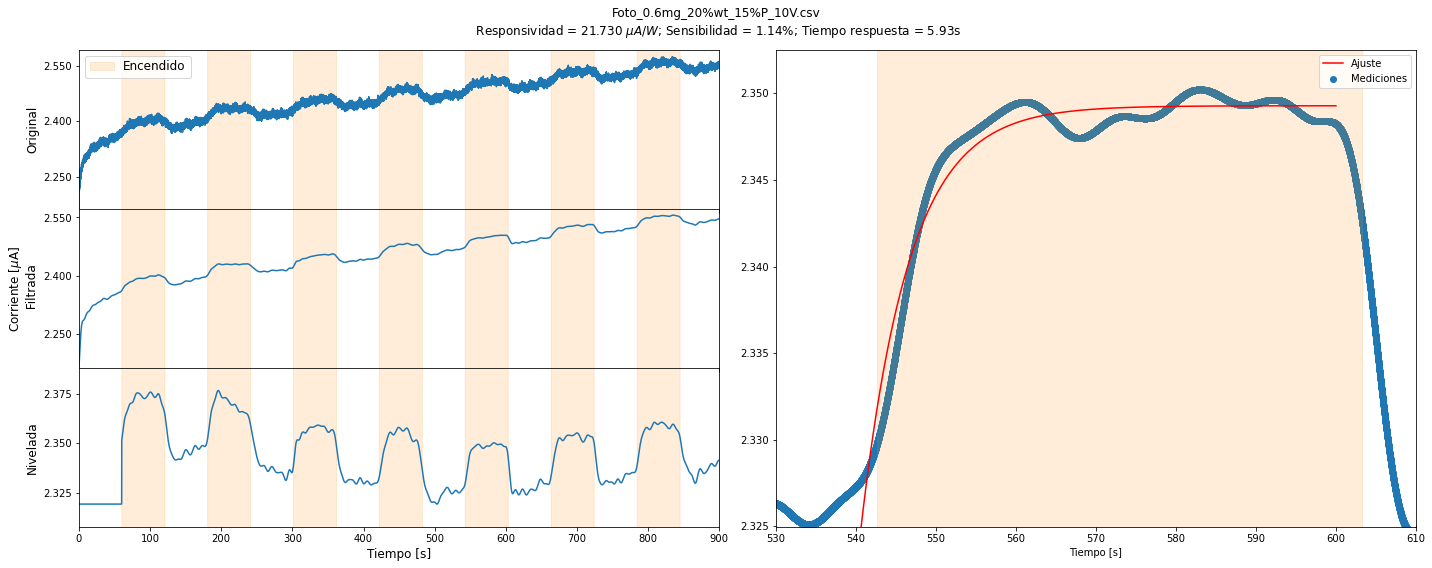

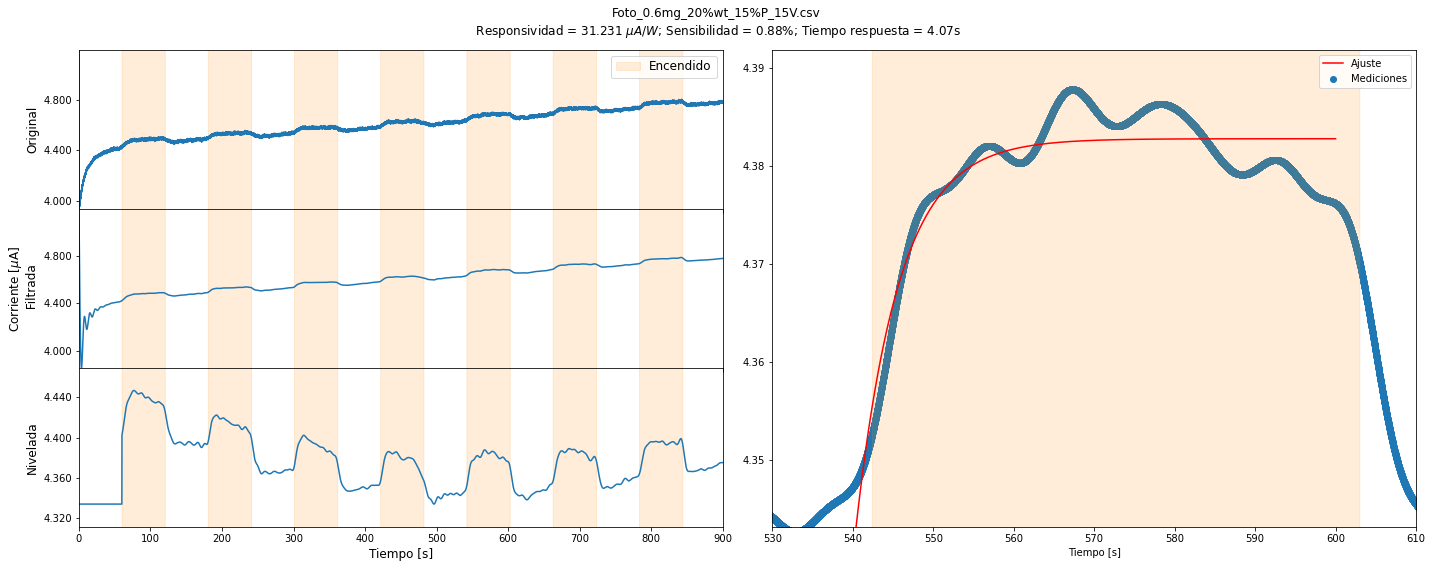

In [7]:
voltajes = [3,5,7.5,10,15]
# voltajes = [7.5]
# voltajes = voltajes[2:]
# responsividades = {}
# sensibilidades = {}
# tiempos = {}
# corrientes = {}
# fotocorrientes = {}

def generate_filenames(phi=20):
    Vs = voltajes if (phi in [5,10,20]) else [7.5,10,15]
    filenames = ['Foto_0.6mg_{}%wt_15%P_{}V.csv'.format(phi,V) for V in Vs ]
    return filenames



rango = (0,100000)
cut = 8/60

phis = [0,1,5,10,20]
# phis = [5,10,20]
# phis = [0,1]
# phis = [20]

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(5,1,hspace=0.2)
ax0,ax1,ax5,ax15,ax20 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0])
axes = (ax0,ax1,ax5,ax15,ax20)

for (phi,ax) in zip(phis,axes):
    
    filenames = generate_filenames(phi)
    plt.figure(figsize=(20,2))
    plt.axis('off')
    plt.title(phi)
    for filename in filenames:
        
        fig1 = plt.figure(figsize=(20,8))
        fig2,ax1 = plt.subplots(figsize=(12,8) )
        gs = fig1.add_gridspec(3,6,hspace=0)
        original,filtrada,corregida,zoom = fig1.add_subplot(gs[0,:3]),fig1.add_subplot(gs[1,:3]),fig1.add_subplot(gs[2,:3]),fig1.add_subplot(gs[:,3:])


        I0,Delta_I0,tau = extraer_datos_foto(filename,(original,filtrada,corregida),filter_function=basic_filter,filter_cut=cut,ajuste=ajuste,rango=rango,ax_single=zoom,reg_avg=ax1)
        r,s,Sr,Ss = calcular_desempeño(I0,Delta_I0,15)
#         ax.set_ylabel('{}%wt-G'.format(phi))

        fig1.suptitle(filename+'\n Responsividad = {:.3f} $\mu A / W$; Sensibilidad = {:.2f}%; Tiempo respuesta = {:.2f}s'.format(r,s*100,tau))

        fig1.tight_layout()
        plt.close(fig)
#         plt.close(fig1)
        plt.close(fig2)

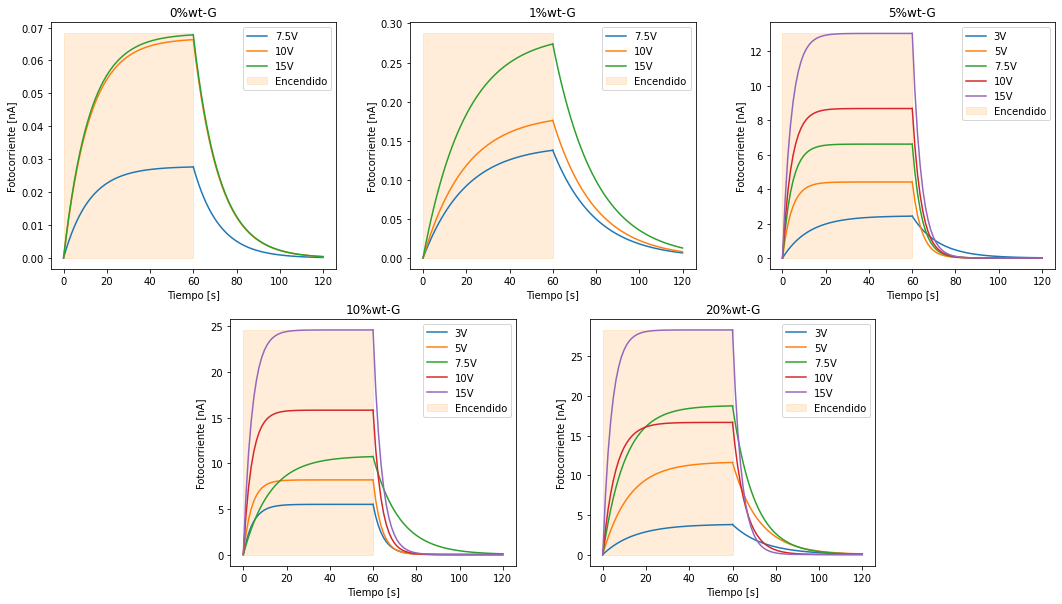

In [12]:
voltajes = [3,5,7.5,10,15]
responsividades = {}
sensibilidades = {}
tiempos = {}
corrientes = {}
fotocorrientes = {}

def exponencial_inversa(x,A,tau,b,start):
    return A*np.exp(-(x-start)/tau) + b

def generate_filenames(phi,Vs):
    filenames = ['Foto_0.6mg_{}%wt_15%P_{}V.csv'.format(phi,V) for V in Vs ]
    return filenames



rango = (0,100000)
cut = 8/60

phis = [0,1,5,10,20]

fig = plt.figure(figsize=(18,10))
gs = fig.add_gridspec(2,6,hspace=0.2,wspace=0.7)
ax0,ax1,ax5,ax10,ax20 = fig.add_subplot(gs[0,:2]),fig.add_subplot(gs[0,2:4]),fig.add_subplot(gs[0,4:]),fig.add_subplot(gs[1,1:3]),fig.add_subplot(gs[1,3:5])
axes = (ax0,ax1,ax5,ax10,ax20)

for (phi,ax) in zip(phis,axes):
    
    Vs = voltajes if (phi in [5,10,20]) else voltajes[2:]
    filenames = generate_filenames(phi,Vs)
    b0 = 9e-4*(phi==0) -8e-4*(phi==1) - 3e-3*(phi==5) - 1.6e-1*(phi==10) - 2.4e-1*(phi==20) 
    b00 = 7e-5*(phi==0) - 3e-5*(phi==1) - 5e-4*(phi==5) - 2e-3*(phi==10) + 1e-2*(phi==20)
#     plt.figure(figsize=(12,8))
#     plt.title('{}%wt grafeno'.format(phi))
    ax.set_title('{}%wt-G'.format(phi))

    responsividades_phi = []
    sensibilidades_phi = []
    tiempos_phi = []
    corrientes_phi = []
    fotocorrientes_phi = []
    
    sigma_r = []
    sigma_s = []
    sigma_t = []
    sigma_I0 = []
    sigma_DI = []
    
    i = 0
    for filename,V in zip(filenames,Vs):
        
        (corriente,tiempo,luz),(I0,Delta_I0,tau),(sigmaI,sigmaDelta,sigmaTau) = procesar_datos_foto(filename,None,rango,basic_filter,cut,
                                                                  True,True,True)
        I0 -= b0
        Delta_I0 -= b00
        r,s,Sr,Ss = calcular_desempeño(I0,Delta_I0,15,sigmaI,sigmaDelta)

        responsividades_phi.append(r)
        sensibilidades_phi.append(s)
        tiempos_phi.append(tau)
        corrientes_phi.append(I0)
        fotocorrientes_phi.append(Delta_I0)
        
        sigma_r.append(Sr)
        sigma_s.append(Ss)
        sigma_t.append(sigmaTau)
        sigma_I0.append(sigmaI)
        sigma_DI.append(sigmaDelta)
        
        tiempo = np.linspace(0,60)
        corriente = exponencial_ajuste(tiempo,Delta_I0,tau,0.)
        corriente_down = exponencial_inversa(tiempo+tiempo[-1],corriente[-1],tau,0.,start=tiempo[-1])

        ax.plot(tiempo,corriente*1e3,label = '{}V'.format(V),color=plt_colors[i])
        ax.plot(tiempo+tiempo[-1],corriente_down*1e3,color=plt_colors[i])
        i+=1
    
    maxima = np.amax(fotocorrientes_phi)
    ax.fill_between(tiempo,maxima*np.ones(len(tiempo))*1e3,alpha=0.15,color='darkorange',label='Encendido')
    
    
    ax.set_xlabel('Tiempo [s]')
    ax.set_ylabel('Fotocorriente [nA]')
    ax.legend()
    responsividades[str(phi)+'%wt-G'] = responsividades_phi    
    sensibilidades[str(phi)+'%wt-G'] = sensibilidades_phi
    corrientes[str(phi)+'%wt-G'] = corrientes_phi
    fotocorrientes[str(phi)+'%wt-G'] = fotocorrientes_phi
    tiempos[str(phi)+'%wt-G'] = tiempos_phi
    
    
    responsividades['Sigma'+str(phi)+'%wt-G'] = sigma_r
    sensibilidades['Sigma'+str(phi)+'%wt-G'] = sigma_s
    corrientes['Sigma'+str(phi)+'%wt-G'] = sigma_I0
    fotocorrientes['Sigma'+str(phi)+'%wt-G'] = sigma_DI
    tiempos['Sigma'+str(phi)+'%wt-G'] = sigma_t

plt.savefig('Fotocorrientes_ajustadas.svg',bbox_inches='tight')

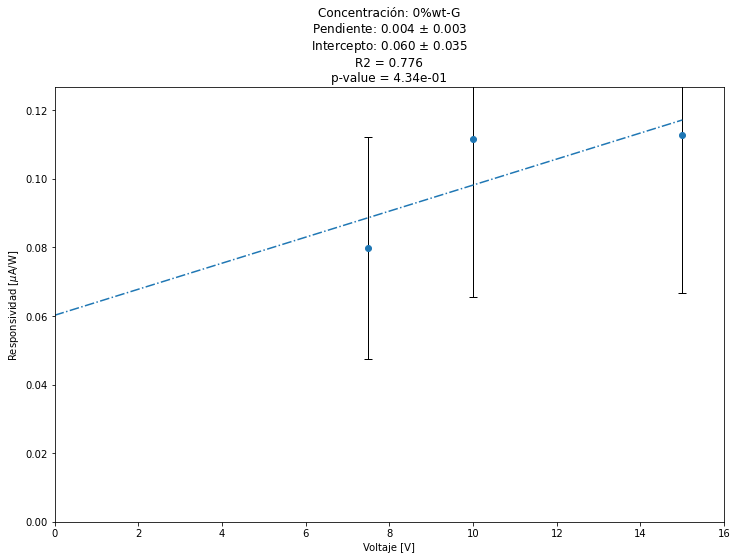

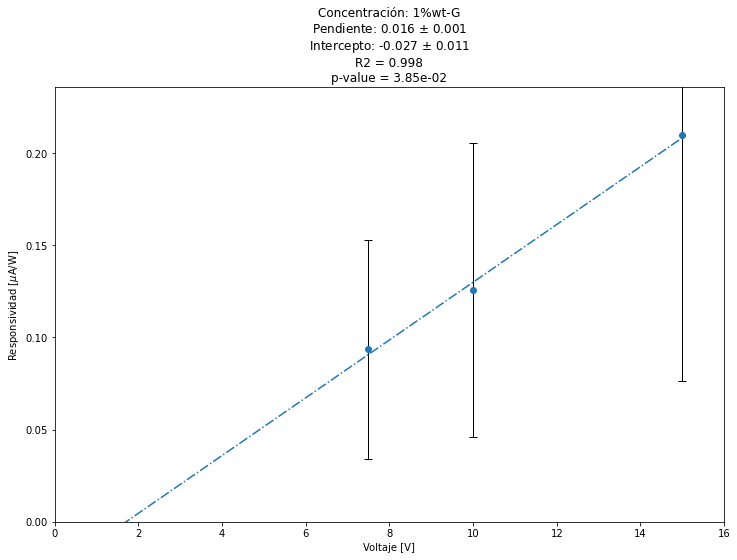

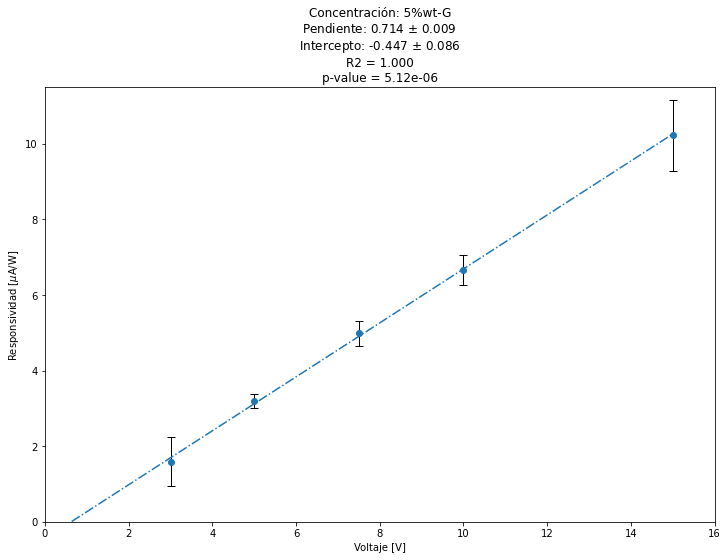

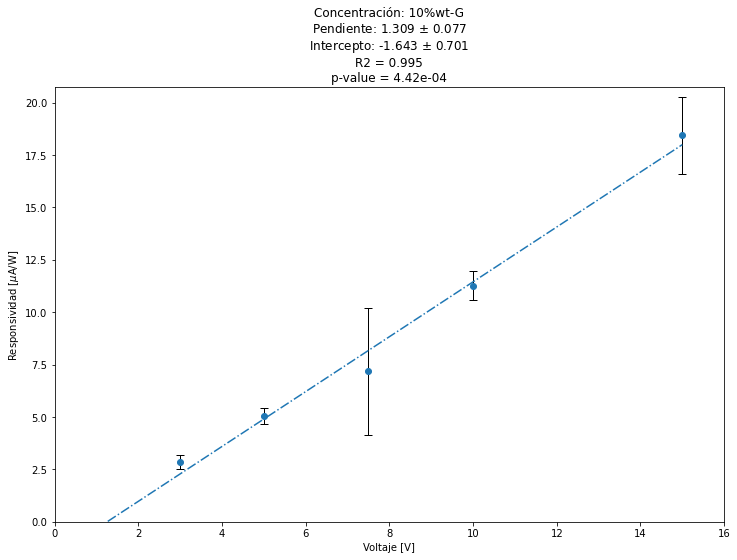

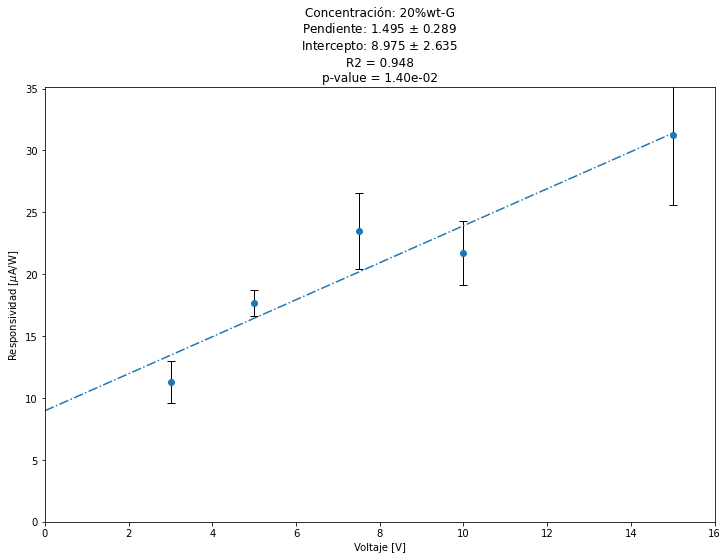

In [9]:
def extraer_datos_rV(voltajes,responsividades,sigma_V=0.,sigma_r=0.):
    plt.figure(figsize=(12,8))
#     plt.scatter(voltajes,responsividades)
    reg = ajuste_lineal( np.array(voltajes),np.array(responsividades),True )
    m,b = reg.slope,reg.intercept
    r,p = reg.rvalue,reg.pvalue
    sigma_m,sigma_b = reg.stderr,reg.intercept_stderr
    
    x = np.linspace(0,np.amax(voltajes))
    y = m*x + b
    # r,p,sigma_m = data
    plt.plot(x,y,linestyle='-.')
    plt.errorbar(voltajes,responsividades,xerr=sigma_V,yerr=sigma_r,elinewidth=1,capsize=4,ecolor='black',marker='o',color=plt_colors[0],linewidth=0)
    plt.xlabel('Voltaje [V]')
    plt.ylabel('Responsividad [$\mu$A/W]')

    plt.xlim(0,16)
    plt.ylim(0,2.25/2*np.amax(responsividades))
    
    return (m,sigma_m),(b,sigma_b),r,p

for phi in phis:
    v = voltajes if phi in [5,10,20] else voltajes[2:]
    responsividades_phi = responsividades[str(phi)+'%wt-G']
    sigma_r = responsividades['Sigma'+str(phi)+'%wt-G']
    
    datos = extraer_datos_rV(v,responsividades_phi,sigma_r=sigma_r)
    (m,sigma_m),(b,sigma_b),r,p = datos
    
    t1 = 'Concentración: {}%wt-G'.format(phi)
    t2 = 'Pendiente: {:.3f} $\pm$ {:.3f}'.format(m,sigma_m)
    t3 = 'Intercepto: {:.3f} $\pm$ {:.3f}'.format(b,sigma_b)
    t4 = 'R2 = {:.3f}'.format(r)
    t5 = 'p-value = {:.2e}'.format(p)
    plt.title(t1+'\n'+t2+'\n'+t3+'\n'+t4+'\n'+t5)
    

0.003127175125118224 0.0037946918137584406
-0.002320506259248789 0.01567403644870277
-0.039415965914590956 0.7136035165598004
-0.013059235925268808 1.3089674405424987
0.8227395873820473 1.4945376670103305


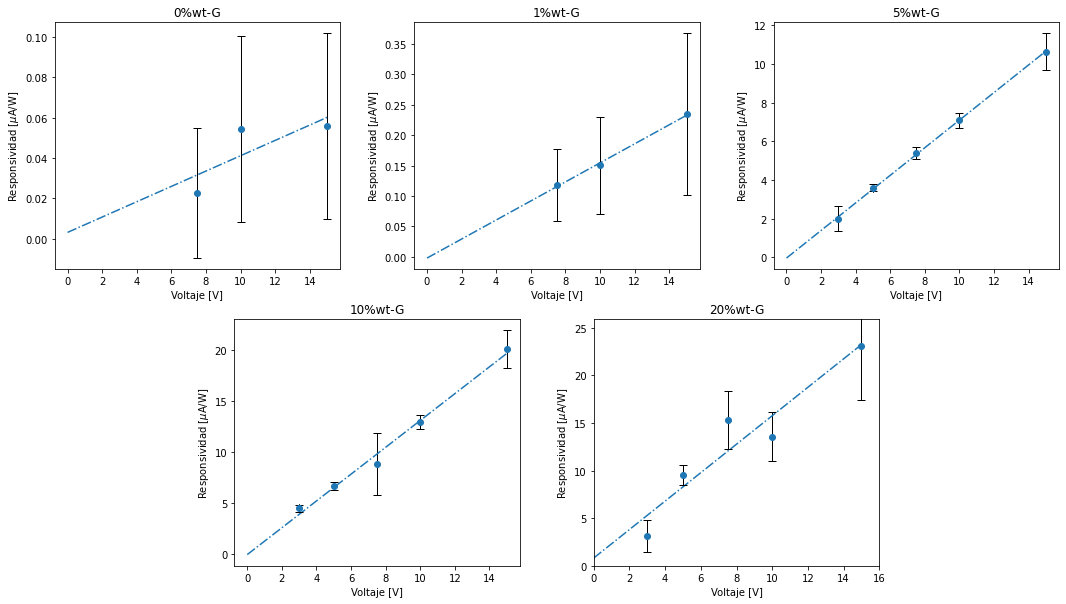

In [99]:
def extraer_datos_rV(voltajes,responsividades,sigma_V=0.,sigma_r=0.,ax=None):
    
    reg = ajuste_lineal( np.array(voltajes),np.array(responsividades),True )
    m,b = reg.slope,reg.intercept
    r,p = reg.rvalue,reg.pvalue
    sigma_m,sigma_b = reg.stderr,reg.intercept_stderr
    
    x = np.linspace(0,np.amax(voltajes))
    y = m*x + b
    # r,p,sigma_m = data
    ax.plot(x,y,linestyle='-.')
    ax.errorbar(voltajes,responsividades,xerr=sigma_V,yerr=sigma_r,elinewidth=1,capsize=4,ecolor='black',marker='o',color=plt_colors[0],linewidth=0)
    ax.set_xlabel('Voltaje [V]')
    ax.set_ylabel('Responsividad [$\mu$A/W]')
    print(b,m)
    plt.xlim(0,16)
    plt.ylim(0,2.25/2*np.amax(responsividades))
    
    return (m,sigma_m),(b,sigma_b),r,p

fig = plt.figure(figsize=(18,10))
gs = fig.add_gridspec(2,6,hspace=0.2,wspace=0.7)
ax0,ax1,ax5,ax10,ax20 = fig.add_subplot(gs[0,:2]),fig.add_subplot(gs[0,2:4]),fig.add_subplot(gs[0,4:]),fig.add_subplot(gs[1,1:3]),fig.add_subplot(gs[1,3:5])
axes = (ax0,ax1,ax5,ax10,ax20)

for (phi,ax) in zip(phis,axes):
    v = voltajes if phi in [5,10,20] else voltajes[2:]
    responsividades_phi = responsividades[str(phi)+'%wt-G']
    sigma_r = responsividades['Sigma'+str(phi)+'%wt-G']
    
    datos = extraer_datos_rV(v,responsividades_phi,sigma_r=sigma_r,ax=ax)
    (m,sigma_m),(b,sigma_b),r,p = datos
    
    t1 = 'Concentración: {}%wt-G'.format(phi)
    t2 = 'Pendiente: {:.3f} $\pm$ {:.3f}'.format(m,sigma_m)
    t3 = 'Intercepto: {:.3f} $\pm$ {:.3f}'.format(b,sigma_b)
    t4 = 'R2 = {:.3f}'.format(r)
    t5 = 'p-value = {:.2e}'.format(p)
    ax.set_title('{}%wt-G'.format(phi))
# plt.savefig('Responsividades.svg',bbox_inches='tight')

0.003836191261121856 0.004655052241130986 214.82036037409566 0.003779505253622141
-0.0028466284991865154 0.019227769231102906 52.008113264766905 0.0011639658898512245
-0.04835264350106083 0.8753969523945413 1.1423389095251273 0.011594700293011592
-0.016020121908443485 1.605746162461017 0.6227634375705863 0.09437611812070915
1.0092771555845204 1.8333902350242322 0.5454376165512755 0.35467780861642983


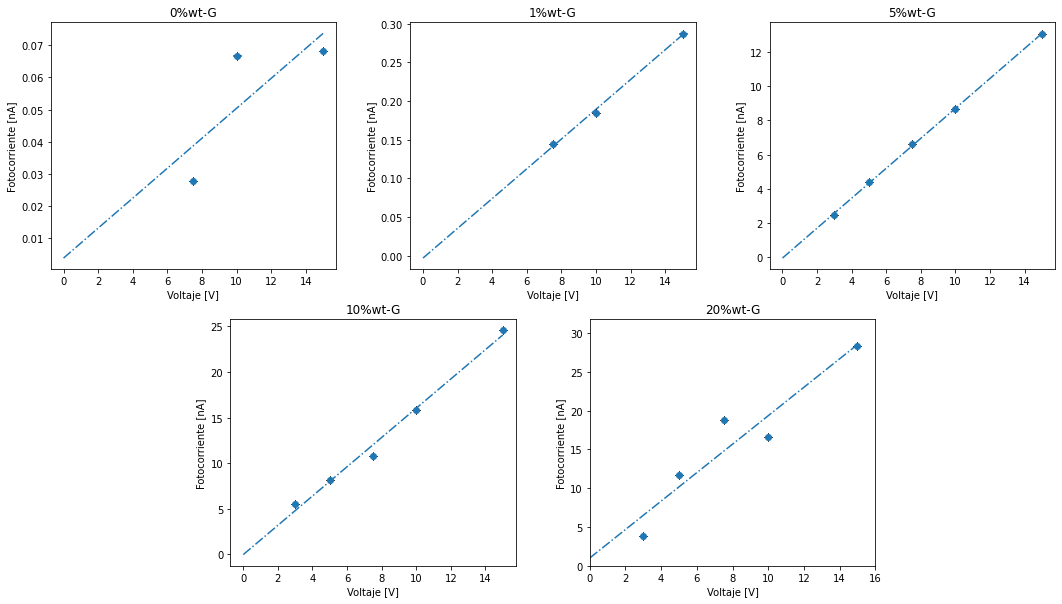

In [19]:
def extraer_datos_rV(voltajes,fotocorrientes,sigma_V=0.,sigma_r=0.,ax=None):
    
    reg = ajuste_lineal( np.array(voltajes),np.array(fotocorrientes)*1e3,True )
    m,b = reg.slope,reg.intercept
    r,p = reg.rvalue,reg.pvalue
    sigma_m,sigma_b = reg.stderr,reg.intercept_stderr
    print(b,m,1/m,sigma_m)
    x = np.linspace(0,np.amax(voltajes))
    y = m*x + b
    # r,p,sigma_m = data
    ax.plot(x,y,linestyle='-.')
    ax.errorbar(voltajes,np.array(fotocorrientes)*1e3,xerr=sigma_V,yerr=sigma_r,elinewidth=1,capsize=4,ecolor='black',marker='o',color=plt_colors[0],linewidth=0)
    ax.set_xlabel('Voltaje [V]')
    ax.set_ylabel('Fotocorriente [nA]')

    plt.xlim(0,16)
    plt.ylim(0,2.25/2*np.amax(fotocorrientes)*1e3)
    
    return (m,sigma_m),(b,sigma_b),r,p

fig = plt.figure(figsize=(18,10))
gs = fig.add_gridspec(2,6,hspace=0.2,wspace=0.7)
ax0,ax1,ax5,ax10,ax20 = fig.add_subplot(gs[0,:2]),fig.add_subplot(gs[0,2:4]),fig.add_subplot(gs[0,4:]),fig.add_subplot(gs[1,1:3]),fig.add_subplot(gs[1,3:5])
axes = (ax0,ax1,ax5,ax10,ax20)

for (phi,ax) in zip(phis,axes):
    v = voltajes if phi in [5,10,20] else voltajes[2:]
    fotocorrientes_phi = fotocorrientes[str(phi)+'%wt-G']
    sigma_r = fotocorrientes['Sigma'+str(phi)+'%wt-G']
    
    datos = extraer_datos_rV(v,fotocorrientes_phi,sigma_r=sigma_r,ax=ax)
    (m,sigma_m),(b,sigma_b),r,p = datos
    
    t1 = 'Concentración: {}%wt-G'.format(phi)
    t2 = 'Pendiente: {:.3f} $\pm$ {:.3f}'.format(m,sigma_m)
    t3 = 'Intercepto: {:.3f} $\pm$ {:.3f}'.format(b,sigma_b)
    t4 = 'R2 = {:.3f}'.format(r)
    t5 = 'p-value = {:.2e}'.format(p)
    ax.set_title('{}%wt-G'.format(phi))
plt.savefig('Fotocorrientes.svg',bbox_inches='tight')

7.25839780525654e-05 1.2917563293925324e-05 77413.98104627557 4.034685616525395
-4.799788519777937e-05 0.0002316893211186641 4316.1246930661555 0.2866172189288763
-0.0007929464164680503 0.007365763203926931 135.76325661227708 0.021035736783536162
-0.002226108716644748 0.06341461932330168 15.76923445525676 0.0784332362472071
-0.0029184222873714916 0.29332427651409926 3.4091961697958295 0.09044001548486258


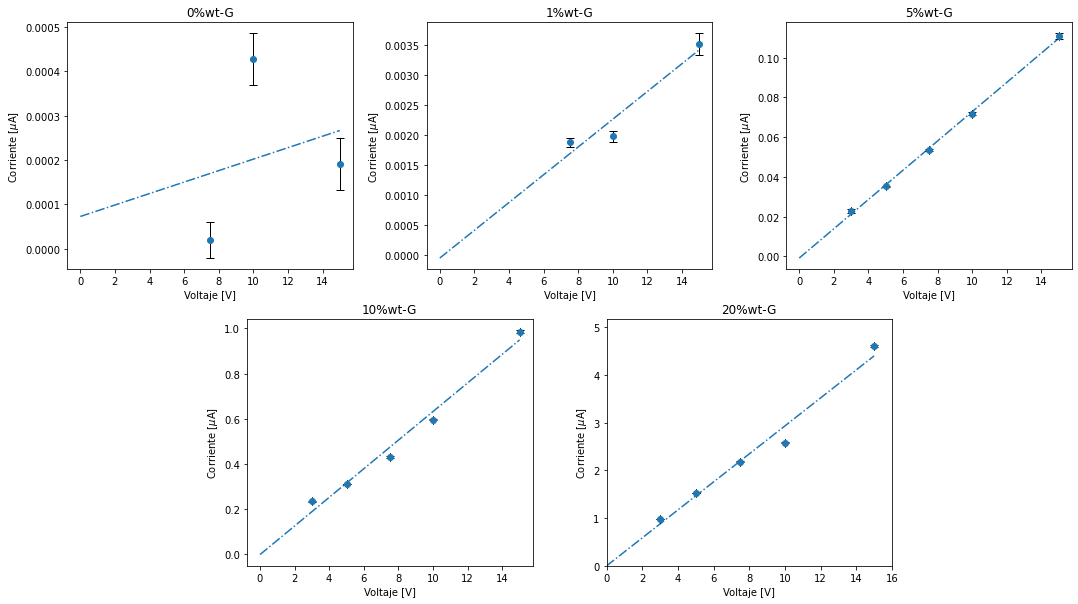

In [108]:
def extraer_datos_rV(voltajes,fotocorrientes,sigma_V=0.,sigma_r=0.,ax=None):
    
    reg = ajuste_lineal( np.array(voltajes),np.array(fotocorrientes),True )
    m,b = reg.slope,reg.intercept
    r,p = reg.rvalue,reg.pvalue
    sigma_m,sigma_b = reg.stderr,reg.intercept_stderr
    print(b,m,1/m,sigma_m/m)
    x = np.linspace(0,np.amax(voltajes))
    y = m*x + b
    # r,p,sigma_m = data
    ax.plot(x,y,linestyle='-.')
    ax.errorbar(voltajes,fotocorrientes,xerr=sigma_V,yerr=sigma_r,elinewidth=1,capsize=4,ecolor='black',marker='o',color=plt_colors[0],linewidth=0)
    ax.set_xlabel('Voltaje [V]')
    ax.set_ylabel('Corriente [$\mu$A]')

    plt.xlim(0,16)
    plt.ylim(0,2.25/2*np.amax(fotocorrientes))
    
    return (m,sigma_m),(b,sigma_b),r,p

fig = plt.figure(figsize=(18,10))
gs = fig.add_gridspec(2,6,hspace=0.2,wspace=0.7)
ax0,ax1,ax5,ax10,ax20 = fig.add_subplot(gs[0,:2]),fig.add_subplot(gs[0,2:4]),fig.add_subplot(gs[0,4:]),fig.add_subplot(gs[1,1:3]),fig.add_subplot(gs[1,3:5])
axes = (ax0,ax1,ax5,ax10,ax20)

for (phi,ax) in zip(phis,axes):
    v = voltajes if phi in [5,10,20] else voltajes[2:]
    fotocorrientes_phi = corrientes[str(phi)+'%wt-G']
    sigma_r = corrientes['Sigma'+str(phi)+'%wt-G']
    
    datos = extraer_datos_rV(v,fotocorrientes_phi,sigma_r=sigma_r,ax=ax)
    (m,sigma_m),(b,sigma_b),r,p = datos
    
    t1 = 'Concentración: {}%wt-G'.format(phi)
    t2 = 'Pendiente: {:.3f} $\pm$ {:.3f}'.format(m,sigma_m)
    t3 = 'Intercepto: {:.3f} $\pm$ {:.3f}'.format(b,sigma_b)
    t4 = 'R2 = {:.3f}'.format(r)
    t5 = 'p-value = {:.2e}'.format(p)
    ax.set_title('{}%wt-G'.format(phi))
# plt.savefig('Corrientes.svg',bbox_inches='tight')

106.17888823801663 65.90747373190368 57.516099533987685
8.318240231935519 8.383937943985538 0.6788175791388008
11.86283966940475 11.886688579335217 0.6479912143823325
2.5280570331613728 2.5317571612702965 0.10816586655140999
0.6521645455590415 0.656218706269291 0.15865970237854388


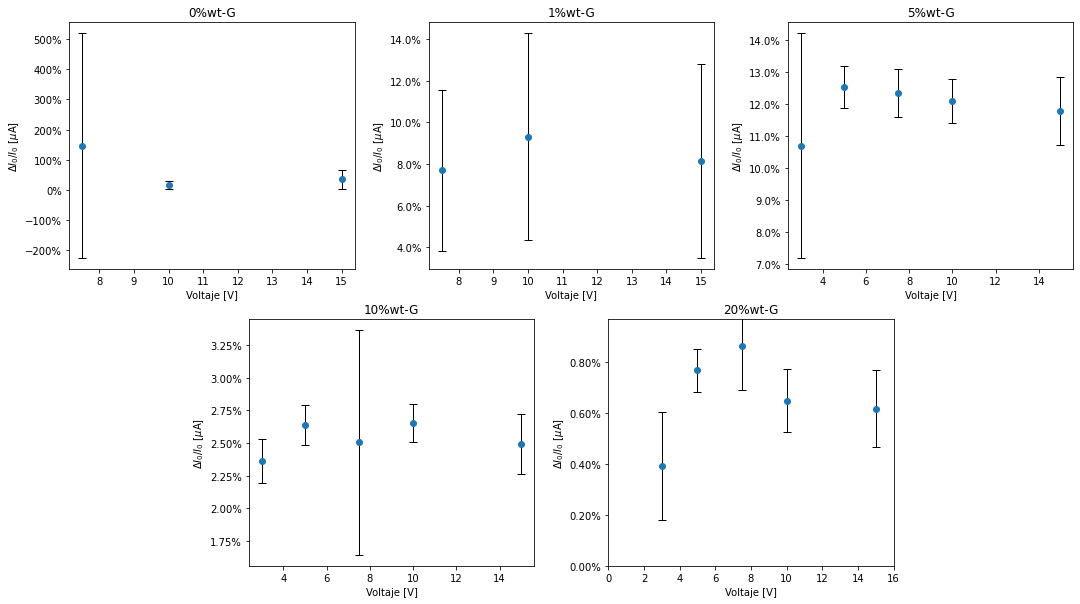

In [116]:
import matplotlib.ticker as mtick

def extraer_datos_rV(voltajes,fotocorrientes,sigma_V=0.,sigma_r=0.,ax=None):
    
    reg = ajuste_lineal( np.array(voltajes),np.array(fotocorrientes),True )
    m,b = reg.slope,reg.intercept
    r,p = reg.rvalue,reg.pvalue
    sigma_m,sigma_b = reg.stderr,reg.intercept_stderr
#     print(b,m,p)
    x = np.linspace(0,np.amax(voltajes))
    y = m*x + b
    print(np.mean(y)*100,np.mean(fotocorrientes)*100,np.std(fotocorrientes)*100)
    # r,p,sigma_m = data
#     ax.plot(x,y,linestyle='-.')
    ax.errorbar(voltajes,np.array(fotocorrientes)*100,xerr=sigma_V,yerr=np.array(sigma_r)*100,elinewidth=1,capsize=4,ecolor='black',marker='o',color=plt_colors[0],linewidth=0)
    ax.set_xlabel('Voltaje [V]')
    ax.set_ylabel('$\Delta I_0$/$I_0$ [$\mu$A]')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    plt.xlim(0,16)
    plt.ylim(0,2.25/2*np.amax(fotocorrientes)*100)
    
    return (m,sigma_m),(b,sigma_b),r,p

fig = plt.figure(figsize=(18,10))
gs = fig.add_gridspec(2,6,hspace=0.2,wspace=0.7)
ax0,ax1,ax5,ax10,ax20 = fig.add_subplot(gs[0,:2]),fig.add_subplot(gs[0,2:4]),fig.add_subplot(gs[0,4:]),fig.add_subplot(gs[1,1:3]),fig.add_subplot(gs[1,3:5])
axes = (ax0,ax1,ax5,ax10,ax20)

for (phi,ax) in zip(phis,axes):
    v = voltajes if phi in [5,10,20] else voltajes[2:]
    fotocorrientes_phi = sensibilidades[str(phi)+'%wt-G']
    sigma_r = sensibilidades['Sigma'+str(phi)+'%wt-G']
    
    datos = extraer_datos_rV(v,fotocorrientes_phi,sigma_r=sigma_r,ax=ax)
    (m,sigma_m),(b,sigma_b),r,p = datos
    
    t1 = 'Concentración: {}%wt-G'.format(phi)
    t2 = 'Pendiente: {:.3f} $\pm$ {:.3f}'.format(m,sigma_m)
    t3 = 'Intercepto: {:.3f} $\pm$ {:.3f}'.format(b,sigma_b)
    t4 = 'R2 = {:.3f}'.format(r)
    t5 = 'p-value = {:.2e}'.format(p)
    ax.set_title('{}%wt-G'.format(phi))
# plt.savefig('sensibilidades.svg',bbox_inches='tight')

0.7361545827818173
0.8373353978733866
0.25997962601212227
0.875067819624623
0.005883319157649192


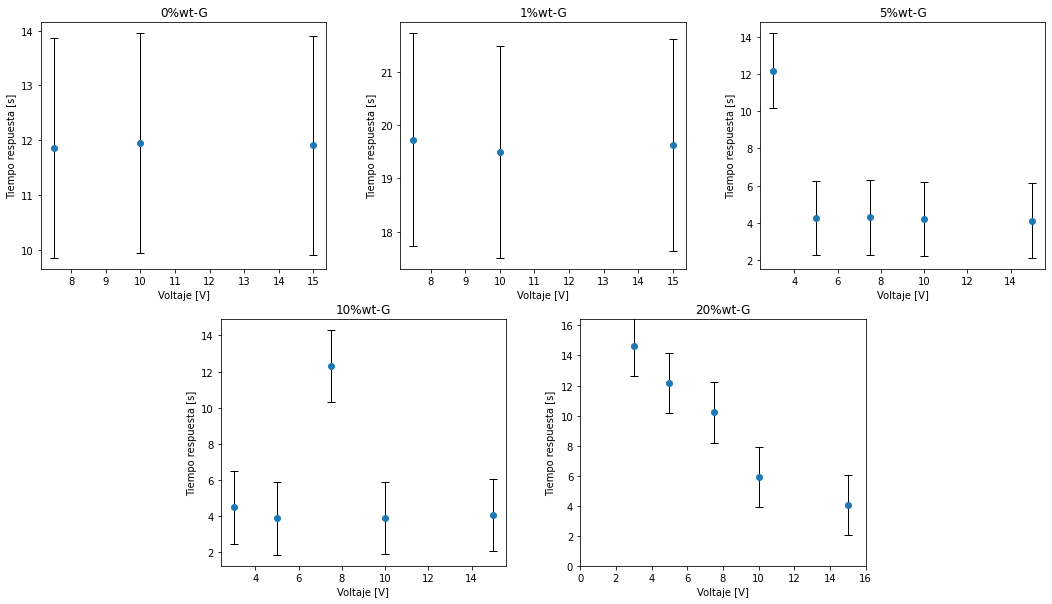

In [117]:
def extraer_datos_rV(voltajes,fotocorrientes,sigma_V=0.,sigma_r=0.,ax=None):
    
    reg = ajuste_lineal( np.array(voltajes),np.array(fotocorrientes),True )
    m,b = reg.slope,reg.intercept
    r,p = reg.rvalue,reg.pvalue
    sigma_m,sigma_b = reg.stderr,reg.intercept_stderr
    
    x = np.linspace(0,np.amax(voltajes))
    y = m*x + b
    # r,p,sigma_m = data
#     ax.plot(x,y,linestyle='-.')
    print(p)
    error = 2
    ax.errorbar(voltajes,fotocorrientes,xerr=sigma_V,yerr=error,elinewidth=1,capsize=4,ecolor='black',marker='o',color=plt_colors[0],linewidth=0)
    ax.set_xlabel('Voltaje [V]')
    ax.set_ylabel('Tiempo respuesta [s]')

    plt.xlim(0,16)
    plt.ylim(0,2.25/2*np.amax(fotocorrientes))
    
    return (m,sigma_m),(b,sigma_b),r,p

fig = plt.figure(figsize=(18,10))
gs = fig.add_gridspec(2,6,hspace=0.2,wspace=0.7)
ax0,ax1,ax5,ax10,ax20 = fig.add_subplot(gs[0,:2]),fig.add_subplot(gs[0,2:4]),fig.add_subplot(gs[0,4:]),fig.add_subplot(gs[1,1:3]),fig.add_subplot(gs[1,3:5])
axes = (ax0,ax1,ax5,ax10,ax20)

for (phi,ax) in zip(phis,axes):
    v = voltajes if phi in [5,10,20] else voltajes[2:]
    fotocorrientes_phi = tiempos[str(phi)+'%wt-G']
    sigma_r = tiempos['Sigma'+str(phi)+'%wt-G']
    
    datos = extraer_datos_rV(v,fotocorrientes_phi,sigma_r=sigma_r,ax=ax)
    (m,sigma_m),(b,sigma_b),r,p = datos
    
    t1 = 'Concentración: {}%wt-G'.format(phi)
    t2 = 'Pendiente: {:.3f} $\pm$ {:.3f}'.format(m,sigma_m)
    t3 = 'Intercepto: {:.3f} $\pm$ {:.3f}'.format(b,sigma_b)
    t4 = 'R2 = {:.3f}'.format(r)
    t5 = 'p-value = {:.2e}'.format(p)
    ax.set_title('{}%wt-G'.format(phi))
# plt.savefig('tiempos.svg',bbox_inches='tight')

4.36008494733927 0.03831236995732242


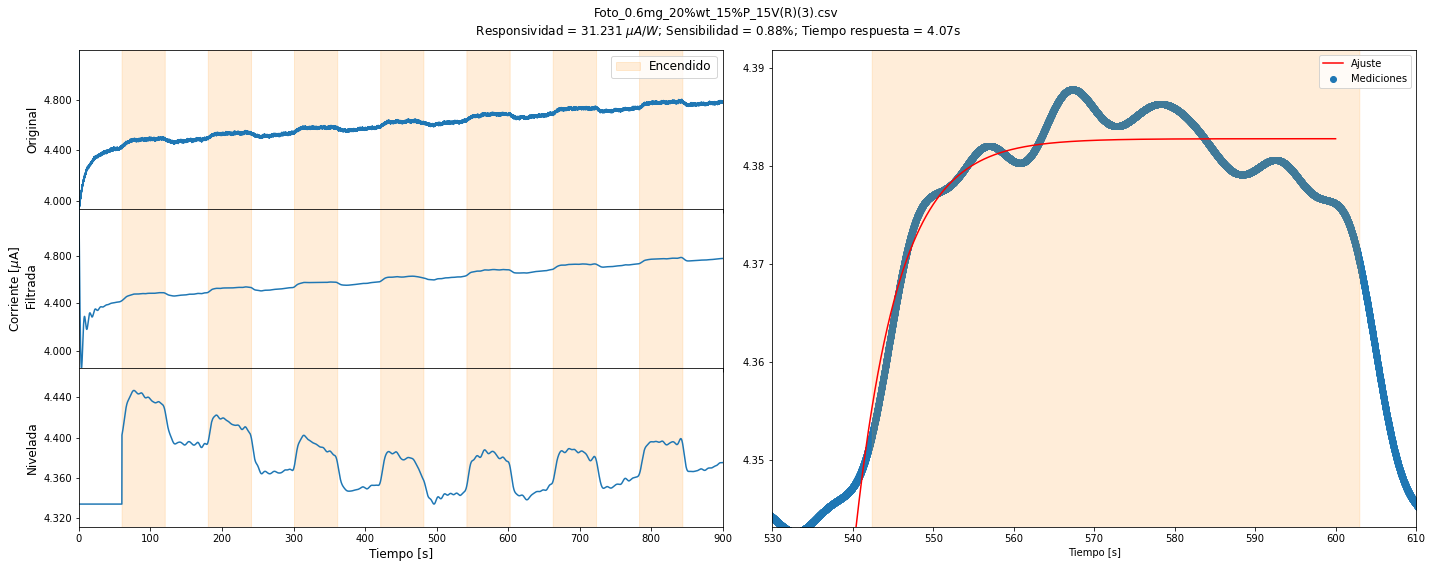

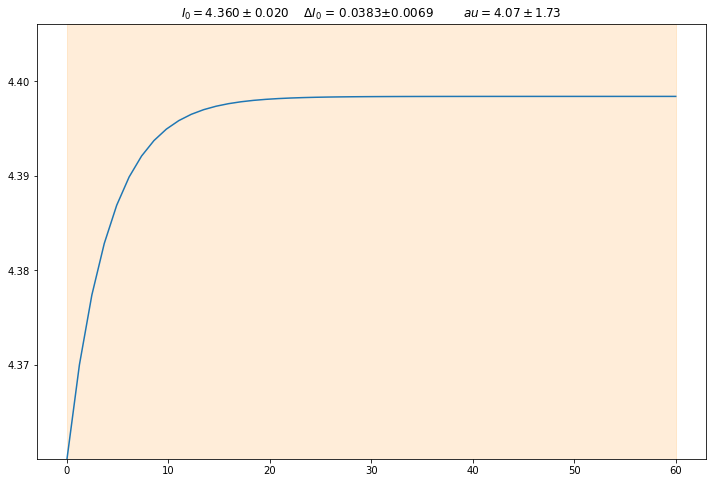

4.36008494733927 0.03831236995732242


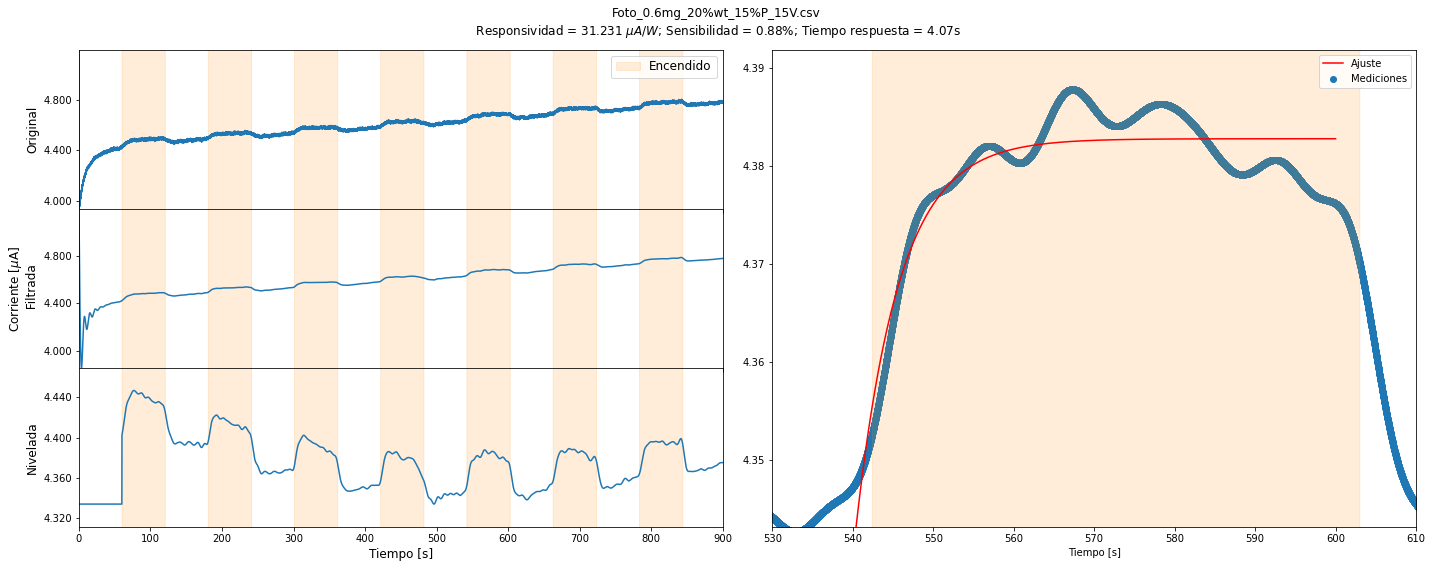

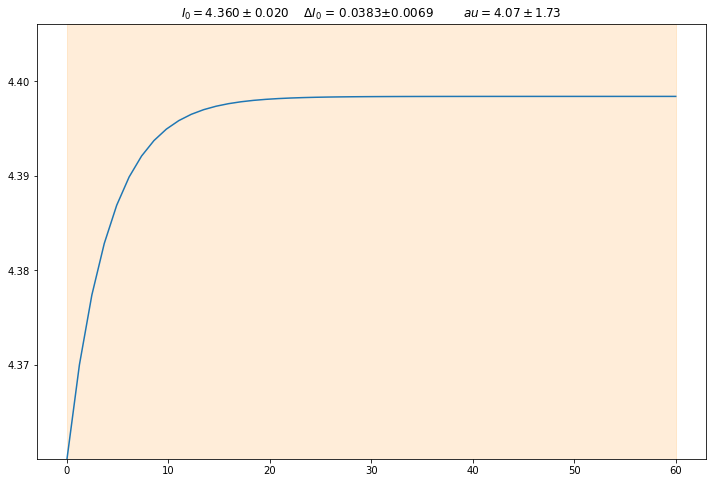

In [15]:
# crear_csvs()
filename = 'Foto_0.6mg_20%wt_15%P_15V(R)(3).csv'

fig = plt.figure(figsize=(20,8))
gs = fig.add_gridspec(3,6,hspace=0)
fig2,ax1 = plt.subplots(figsize=(12,8) )
#     gs = fig.add_gridspec(3,hspace=0)
#     original,filtrada,corregida = gs.subplots(sharex=True, sharey=False)
original,filtrada,corregida,zoom = fig.add_subplot(gs[0,:3]),fig.add_subplot(gs[1,:3]),fig.add_subplot(gs[2,:3]),fig.add_subplot(gs[:,3:])


I0,Delta_I0,tau = extraer_datos_foto(filename,(original,filtrada,corregida),filter_function=basic_filter,filter_cut=cut,ajuste=ajuste,rango=rango,ax_single=zoom,reg_avg=ax1)
print(I0,Delta_I0)
r,s,Sr,Ss = calcular_desempeño(I0,Delta_I0,15)

r_20_new = r
s_20_new = s
i0_20_new = I0
delta_i0_20_new = Delta_I0

fig.suptitle(filename+'\n Responsividad = {:.3f} $\mu A / W$; Sensibilidad = {:.2f}%; Tiempo respuesta = {:.2f}s'.format(r,s*100,tau))

fig.tight_layout()
plt.show(fig)

# crear_csvs()
filename = 'Foto_0.6mg_20%wt_15%P_15V.csv'

fig = plt.figure(figsize=(20,8))
gs = fig.add_gridspec(3,6,hspace=0)
fig2,ax1 = plt.subplots(figsize=(12,8) )
#     gs = fig.add_gridspec(3,hspace=0)
#     original,filtrada,corregida = gs.subplots(sharex=True, sharey=False)
original,filtrada,corregida,zoom = fig.add_subplot(gs[0,:3]),fig.add_subplot(gs[1,:3]),fig.add_subplot(gs[2,:3]),fig.add_subplot(gs[:,3:])


I0,Delta_I0,tau = extraer_datos_foto(filename,(original,filtrada,corregida),filter_function=basic_filter,filter_cut=cut,ajuste=ajuste,rango=rango,ax_single=zoom,reg_avg=ax1)
print(I0,Delta_I0)
r,s,Sr,Ss = calcular_desempeño(I0,Delta_I0,15)

r_20_new = r
s_20_new = s
i0_20_new = I0
delta_i0_20_new = Delta_I0

fig.suptitle(filename+'\n Responsividad = {:.3f} $\mu A / W$; Sensibilidad = {:.2f}%; Tiempo respuesta = {:.2f}s'.format(r,s*100,tau))

fig.tight_layout()
plt.show(fig)

[0.982654099017624, 1.5257597896498245, 2.183499299729725, 2.5730429516477207, 4.60008494733927]
[0.0038444911825626267, 0.01169387856591046, 0.018790760699270388, 0.016657189891338103, 0.02831236995732242]
[0.003912354496262754, 0.007664298564713329, 0.008605801110903182, 0.0064737317659898375, 0.006154749375595454]


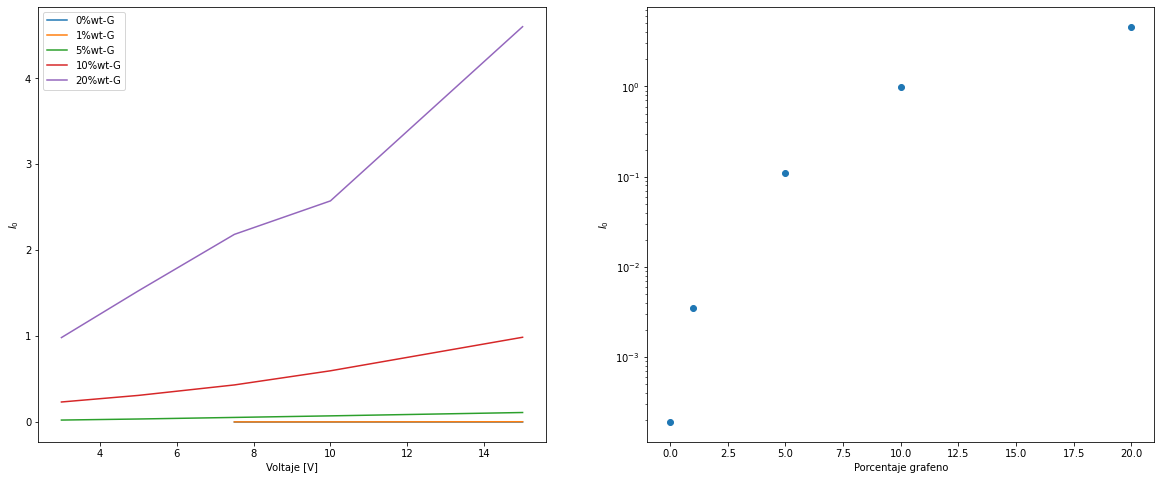

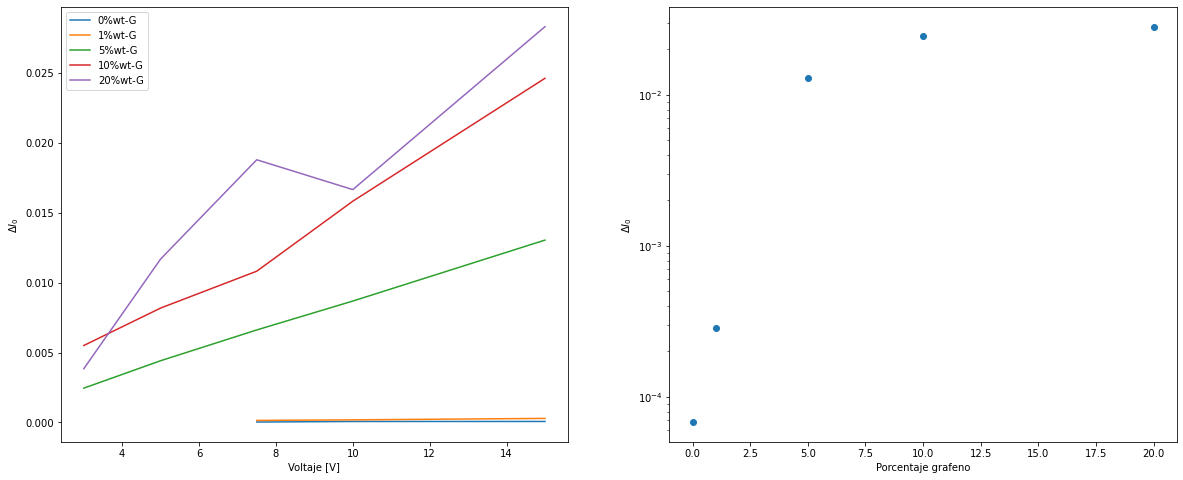

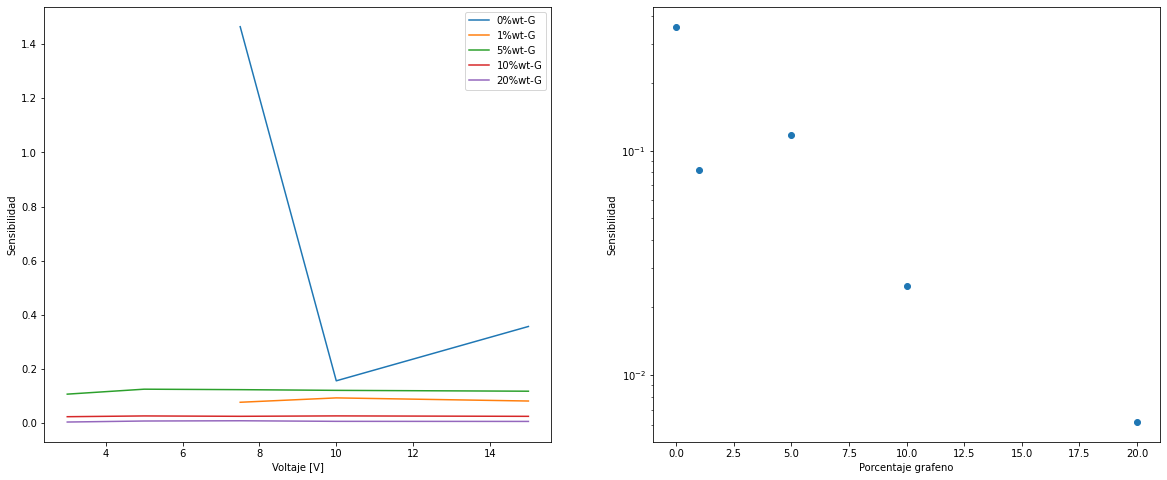

In [95]:
for conjunto,nombre in zip([corrientes,fotocorrientes,sensibilidades],['$I_0$','$\Delta I_0$','Sensibilidad']):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
    
    for phi in phis:
        v = voltajes if phi in [5,10,20] else voltajes[2:]
        conjunto_phi = conjunto[str(phi)+'%wt-G']
        if phi==20: print(conjunto_phi)
        ax1.plot(v,conjunto_phi,label=str(phi)+'%wt-G')
#         ax2.scatter(phi,conjunto_phi[-1],c=plt_colors[0])
        ax2.scatter(phi,conjunto_phi[-1],c=plt_colors[0])
        
#     if nombre == 'Sensibilidad': ax2.scatter(20,s_20_new,c=plt_colors[1])
#     if nombre == '$\Delta I_0$': ax2.scatter(20,delta_i0_20_new,c=plt_colors[1])
#     if nombre == '$I_0$': ax2.scatter(20,i0_20_new,c=plt_colors[1])
    ax1.legend()
    ax2.set_yscale('log')
    
    ax1.set_xlabel('Voltaje [V]')
    ax1.set_ylabel(nombre)
    ax2.set_xlabel('Porcentaje grafeno')
    ax2.set_ylabel(nombre)

0.0005224118377676176


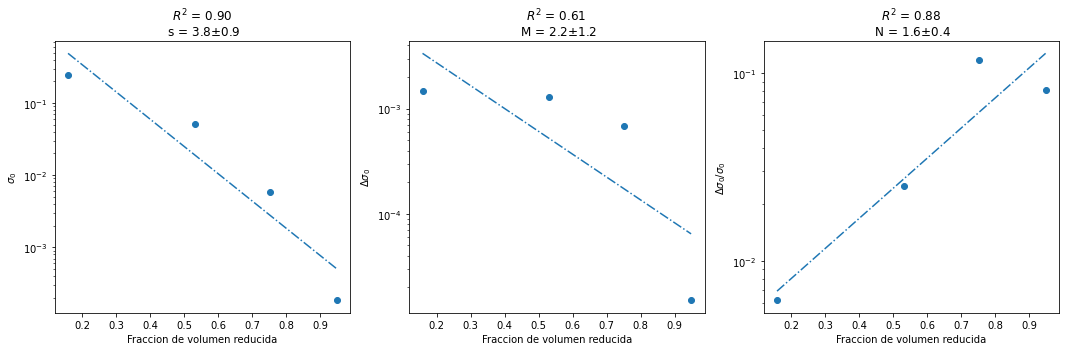

In [120]:
valores = {}
incertidumbres = {}

M_fc = 25
rho_mos = 5.06

# for M_fc in np.linspace(5,51,10):
    
#     plt.figure()
#     plt.axis('off')
#     plt.title(M_fc)

def phi_func(phi):
    num = 1 - phi/M_fc
    den = 1 + phi/100*(5.06/2.2 - 1)
    return num/den

for conjunto,nombre in zip([corrientes,fotocorrientes,sensibilidades],['$I_0$','$\Delta I_0$','Sensibilidad']):
    lista = []
    lista_in = []
    for phi in phis[1:]:
        v = voltajes if phi in [5,10,20] else voltajes[2:]
        conjunto_phi = conjunto[str(phi)+'%wt-G']
        sigmas_phi = conjunto['Sigma'+str(phi)+'%wt-G']
#         lista.append(conjunto_phi[-1])
#         lista_in.append(sigmas_phi[-1])
        lista.append(conjunto_phi[-1])
        lista_in.append(sigmas_phi[-1])
    valores[nombre] = lista
    incertidumbres[nombre] = lista_in

i = 0
A = np.pi*(1.7/2)**2
t = 0.6e-3/(A*rho_mos)*1e1

A1 = 17/2*t
A2 = 17*np.cos(np.arcsin(3*2/17))*t
A3 = 17*np.cos(np.arcsin(6*2/17))*t
    
AT = 1e-3/(1/A1+2/A2+2/A3)

prefactor = 1/15/AT


print(t)

fig,axes = plt.subplots(1,3,figsize=(18,5))
labels = ['$\sigma_0$','$\Delta\sigma_0$','$\Delta\sigma_0/\sigma_0$']
coefs = ['s','M','N']

# xticks = [[2,3,4,5,6],[1,2,3,4],[-2,-1,0]]

for (nombre,ax,label,coef) in zip(valores.keys(),axes,labels,coefs):
    lista = valores[nombre] if i==2 else np.array(valores[nombre])*1e-6*prefactor
    log_lista = np.log10(lista)
    sigma_lista = np.array(incertidumbres[nombre])
    sigma_log = np.array(incertidumbres[nombre])/np.array(lista)
    true_phis = phi_func(np.array(phis[1:]))
    reg = ajuste_lineal( true_phis,np.array(log_lista),True )
    m,b = reg.slope,reg.intercept
    r,p = reg.rvalue**2,reg.pvalue
    sigma_m,sigma_b = reg.stderr,reg.intercept_stderr

    x = np.linspace(np.amin(true_phis),np.amax(true_phis))
    y = m*x + b

    ax.plot(x,10**y,linestyle='-.')
#     plt.scatter(true_phis,log_lista)
    ax.set_title('$R^2$ = {:.2f} \n {} = {:.1f}$\pm${:.1f}'.format(r,coef,np.abs(m),sigma_m) )
    ax.errorbar(true_phis,10**log_lista,elinewidth=1,capsize=4,ecolor='black',marker='o',color=plt_colors[0],linewidth=0)
    ax.set_ylabel(label)
    ax.set_yscale('log')
    ax.set_xlabel('Fraccion de volumen reducida')
#     if i != 2: ax.set_ylim(10**(-6),1)
#     if i ==2: ax.set_ylim(10**(-3),)
    i+=1

#     plt.yticks([-2,-1,0])
#     plt.xticks(range(0,21,2))
#     plt.yscale('log')
plt.savefig('coeficientes_percolacion.svg',bbox_inches='tight')

In [18]:
print(phi_func(np.array(phis)))

[1.         0.94768016 0.75117371 0.53097345 0.15873016]


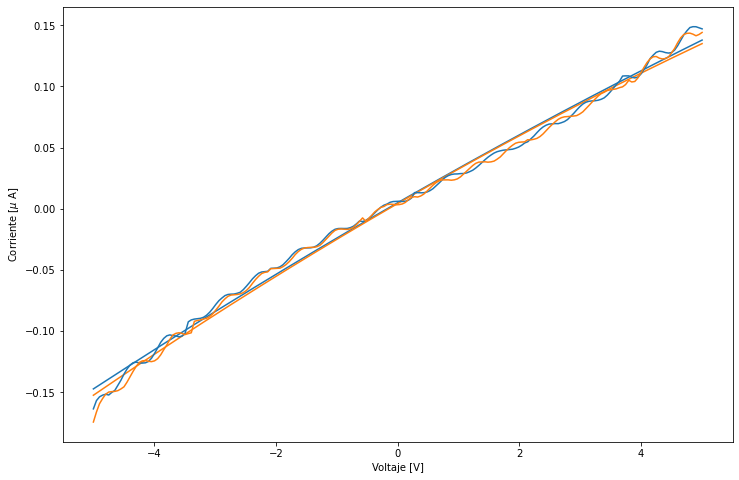

In [19]:
def extraer_datos_IV(phi,plot_fit=False,plot_only_fit=False,accumulate=False):
    
    plot_fit = plot_fit or plot_only_fit
    
    dataD = pd.read_csv('Fotoconductividad/I_vs_V\IvsV_0.6mg_{}%wtG_Dark.csv'.format(phi) )
    dataL = pd.read_csv('Fotoconductividad/I_vs_V\IvsV_0.6mg_20%wtG_Light.csv'.format(phi) )
    
    V_D = dataD['Voltaje [V]']
    I_D = dataD['Corriente [A]']*1e6
    
    V_L = dataL['Voltaje [V]']
    I_L = dataL['Corriente [A]']*1e6 #microamperios
    
    if not accumulate: plt.figure(figsize=(12,8))
    if plot_fit:
        ID_fit = ajuste( np.array(V_D),np.array(I_D) )
        IL_fit = ajuste( np.array(V_L),np.array(I_L) )
        
        plt.plot(V_D,ID_fit,color=plt_colors[0])
        plt.plot(V_L,IL_fit,color=plt_colors[1])
    if not plot_only_fit:
        plt.plot(V_D,I_D,color=plt_colors[0])
        plt.plot(V_L,I_L,color=plt_colors[1])
        
    plt.xlabel('Voltaje [V]')
    plt.ylabel('Corriente [$\mu$ A]')
    
extraer_datos_IV(20,True)

Notas para preguntar.

- Tengo curvas de fotoconductividad (variando V). Las filtro, las nivelo, extraigo un diente y le hago el ajuste exponencial. Dónde tomo I0?
- Qué debería hacer con los tiempos de respuesta?

- He intentado sacar curvas I vs V, pero la fuente se putea. 
- Estoy sacando curvas de fotoconductividad (variando P)
- Estoy viendo las fotocurvas de dos componentes como Castellanos para P = 30%
- La relación entre responsividad/sensibilidad y composición es muy errática
- Los dispositivos de 0% y 1% no responden lo suficiente, planeo cambiarlos por 0.8mg (si calculo sigma, uso regla de 3)

- Debería sacar los exponentes de percolación?
- Para calcular el área aproximo como rectángulos

- MEDIDA DE POTENCIA DE LA LÁMPARA Y CÁLCULO DE RESPONSIVIDAD

- En Raman estoy ajustando los dos picos al tiempo


In [20]:
sigma0 = np.random.rand()/1000
mu0 = 10*np.random.rand()

In [21]:
dd = np.floor(np.log10(sigma0))
np.floor(sigma0*10**(-dd))*10**(dd)
# int(mu0*10**(-dd))*10**(dd)

0.0004

In [22]:
def report_significant(mu0,sigma0):
    dd = np.floor(np.log10(sigma0))
    sigma = np.floor(sigma0*10**(-dd))*10**(dd)
    mu = np.floor(mu0*10**(-dd))*10**(dd)
    return mu,sigma
report_significant(mu0,sigma0)

(5.9750000000000005, 0.0004)